# Feeding the Mind: How Diet Composition Relates to Population Mental Health

This notebook explores the potential relationship between national dietary patterns and mental health outcomes using two large-scale, publicly available datasets: the Global Dietary Database (GDD) and the Global Mental Health Disorders dataset.

Inspired by emerging research on the gut-brain axis—including insights from neuroscientist Dr. Diego Bohórquez on how food preferences and mood may be influenced by gut chemosensation, this project investigates how diet composition at the population level may correlate with the prevalence of various mental health disorders.

We focus on engineered dietary features such as plant-based, animal-based, and processed diet scores, as well as dietary diversity, and analyze their associations with mental health outcomes including anxiety, depression, schizophrenia, bipolar disorder, eating disorders, drug use, and alcohol use. The goal is not to establish causality but to identify broad global trends and support future, more targeted research in nutritional psychiatry.

In [1]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from helpers import null_analysis as na
from helpers import scoring
from helpers import analysis

import sys
sys.path.append('helpers')
sys.path.append('.') 

In [2]:
# Load Global Dietary Database (GDD) dataset

gdd_df = pd.read_csv('Datasets/gdd.csv', low_memory=False)
print(f"Total number of rows: {gdd_df.size}")
print(gdd_df['Representativeness'].unique())

Total number of rows: 25776
['National' 'Local' 'Subnational' '9 MISSING']


In [3]:
# Filter the dataframe based on the following conditions:
# - National level
# - Years between 1990 and 2017 (inclusive)

gdd_df = gdd_df[
    (gdd_df['Representativeness'] == 'National') &
    (gdd_df['Year'] >= 1990) &
    (gdd_df['Year'] <= 2017)
]
print(f"Total number of rows: {gdd_df.size}")

Total number of rows: 16288


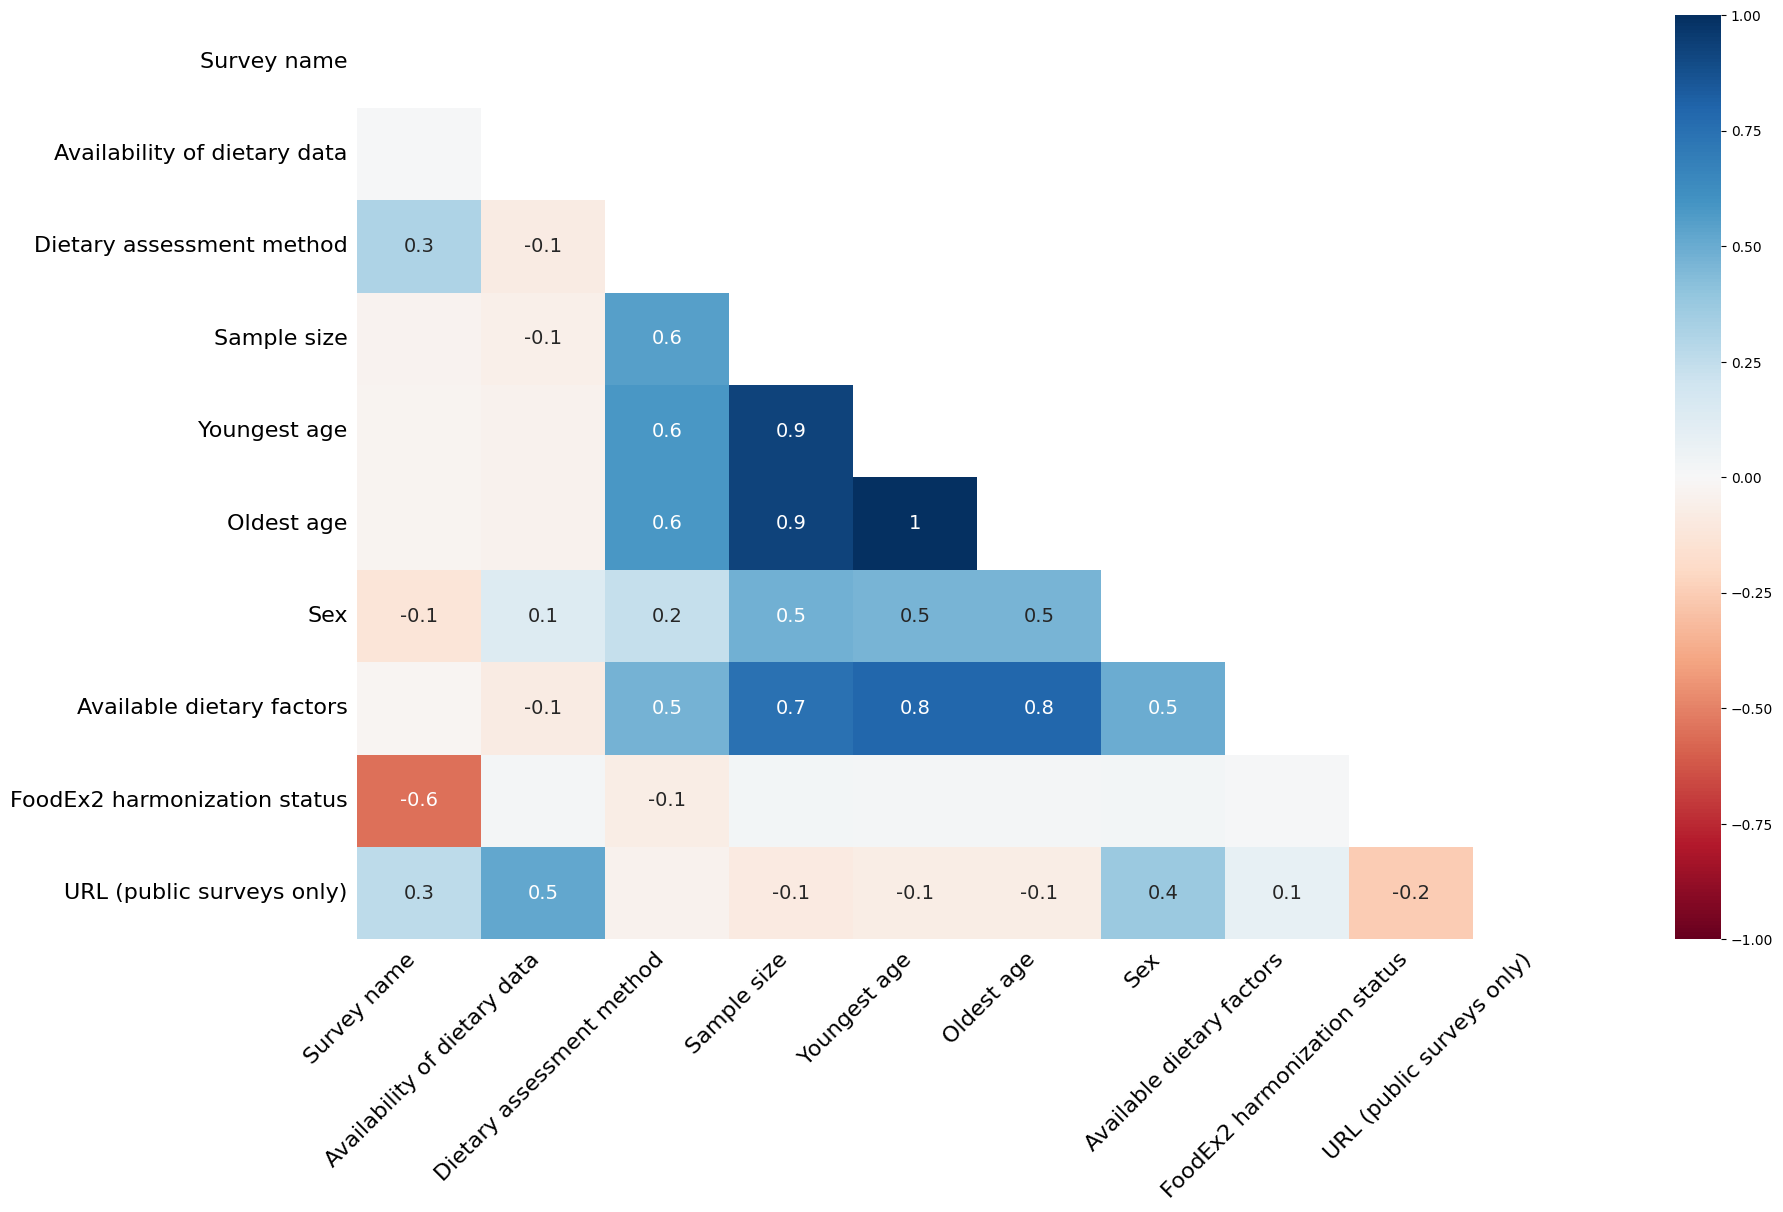

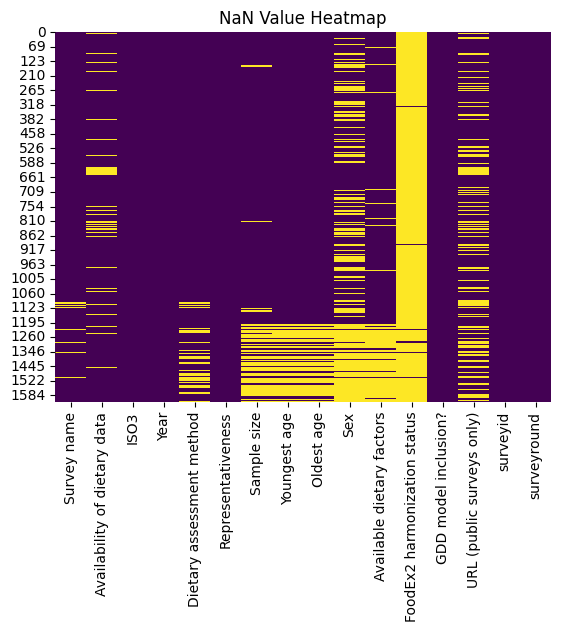

Count of NaN values per column:
Survey name                      27
Availability of dietary data     97
ISO3                              0
Year                              0
Dietary assessment method        83
Representativeness                0
Sample size                     152
Youngest age                    139
Oldest age                      139
Sex                             423
Available dietary factors       203
FoodEx2 harmonization status    988
GDD model inclusion?              0
URL (public surveys only)       286
surveyid                          0
surveyround                       0
dtype: int64

Percentage of NaN values per column:
Survey name                      2.652259
Availability of dietary data     9.528487
ISO3                             0.000000
Year                             0.000000
Dietary assessment method        8.153242
Representativeness               0.000000
Sample size                     14.931238
Youngest age                    13.654224
Oldes

In [4]:
# Explore missing values in GDD dataset

# Heatmap of missing values correlation (Missingno)
msno.heatmap(gdd_df)
plt.show()

# Basic heatmap of NaN values (Seaborn)
sns.heatmap(gdd_df.isna(), cbar=False, cmap='viridis')
plt.title('NaN Value Heatmap')
plt.show()

# Count NaN values per column
print("Count of NaN values per column:")
print(gdd_df.isna().sum())

# Percentage of NaN values per column
print("\nPercentage of NaN values per column:")
print(gdd_df.isna().mean() * 100)

In [5]:
# Inspect 'Sex' column in GDD
gdd_df.columns

# Print absolute counts of each value in the 'Sex' column (including NaN)
print(gdd_df['Sex'].value_counts(dropna=False))

# Print relative proportions (%) of each value in the 'Sex' column (including NaN)
print(gdd_df['Sex'].value_counts(normalize=True, dropna=False) * 100)

Sex
Male|Female    593
NaN            423
Male             1
Female           1
Name: count, dtype: int64
Sex
Male|Female    58.251473
NaN            41.552063
Male            0.098232
Female          0.098232
Name: proportion, dtype: float64


In [6]:
# Process 'Available dietary factors' and clean GDD dataframe

# Drop rows with missing values
gdd_df = gdd_df.dropna(subset=['Available dietary factors'])

# Convert 'Year' to numeric, handling any non-numeric values
pd.to_numeric(gdd_df['Year'], errors='coerce')
# Drop rows where 'Year' is missing
gdd_df = gdd_df.dropna(subset=['Year'])
# Convert 'Year' to integer
gdd_df['Year'] = gdd_df['Year'].astype(int)

# Drop unnecessary columns
gdd_df = gdd_df.drop(
    columns=['Survey name', 'Availability of dietary data', 'Dietary assessment method', 'Representativeness', 
    'Sample size', 'Sex','FoodEx2 harmonization status', 'GDD model inclusion?',
    'URL (public surveys only)', 'surveyid', 'surveyround']
)

gdd_df

,ISO3,Year,Youngest age,Oldest age,Available dietary factors
1,ALB,2008,0.0,98.0,Fruits|Non-Starchy Vegetables|Other Starchy Ve...
2,ARE,2010,11.0,16.0,Fruits|Non-Starchy Vegetables|Sugar-Sweetened ...
3,ARE,2009,6.0,50.0,Total Energy|Total Carbohydrates|Total Protein...
4,ARE,2005,11.0,16.0,Fruits|Non-Starchy Vegetables|Fruits|Non-Starc...
5,ARE,2003,18.0,90.0,Fruits|Non-Starchy Vegetables|Fruits|Non-Starc...
...,...,...,...,...,...
1589,USA,2005,0.0,100.0,Fruits|Non-Starchy Vegetables|Potatoes|Other S...
1592,USA,2003,0.0,100.0,Fruits|Non-Starchy Vegetables|Beans and Legume...
1593,USA,2001,0.0,100.0,Fruits|Non-Starchy Vegetables|Beans and Legume...
1595,USA,1999,0.0,100.0,Fruits|Non-Starchy Vegetables|Beans and Legume...


In [7]:
# Load and clean Global Mental Health Disorders dataset

mental_health_df = pd.read_csv('Datasets/mental_health.csv', low_memory=False)

# Convert 'Year' to numeric, handling any non-numeric values
mental_health_df['Year'] = pd.to_numeric(mental_health_df['Year'], errors='coerce')
# Drop rows where 'Year' is missing
mental_health_df = mental_health_df.dropna(subset=['Year'])
# Convert 'Year' to integer
mental_health_df['Year'] = mental_health_df['Year'].astype(int)

# Rename 'Code' column to 'ISO3'
mental_health_df = mental_health_df.rename(columns={'Code': 'ISO3'})

# Drop rows where 'ISO3' is missing or is 'OWID_WRL'
# NOTE: 'OWID_WRL' stands for 'Our World In Data - World' (global aggregate row)
mental_health_df = mental_health_df.dropna(subset=['ISO3']) 
mental_health_df = mental_health_df[mental_health_df['ISO3'] != 'OWID_WRL']

# Rename columns to make it easier to work with
rename_map = {
    'Schizophrenia (%)': 'schizophrenia',
    'Bipolar disorder (%)': 'bipolar',
    'Eating disorders (%)': 'eating_disorder',
    'Anxiety disorders (%)': 'anxiety',
    'Drug use disorders (%)': 'drug_use',
    'Depression (%)': 'depression',
    'Alcohol use disorders (%)': 'alcohol_use'
}
mental_health_df = mental_health_df.rename(columns=rename_map)

print(f"Total number of rows: {mental_health_df.size}")

Total number of rows: 1130580


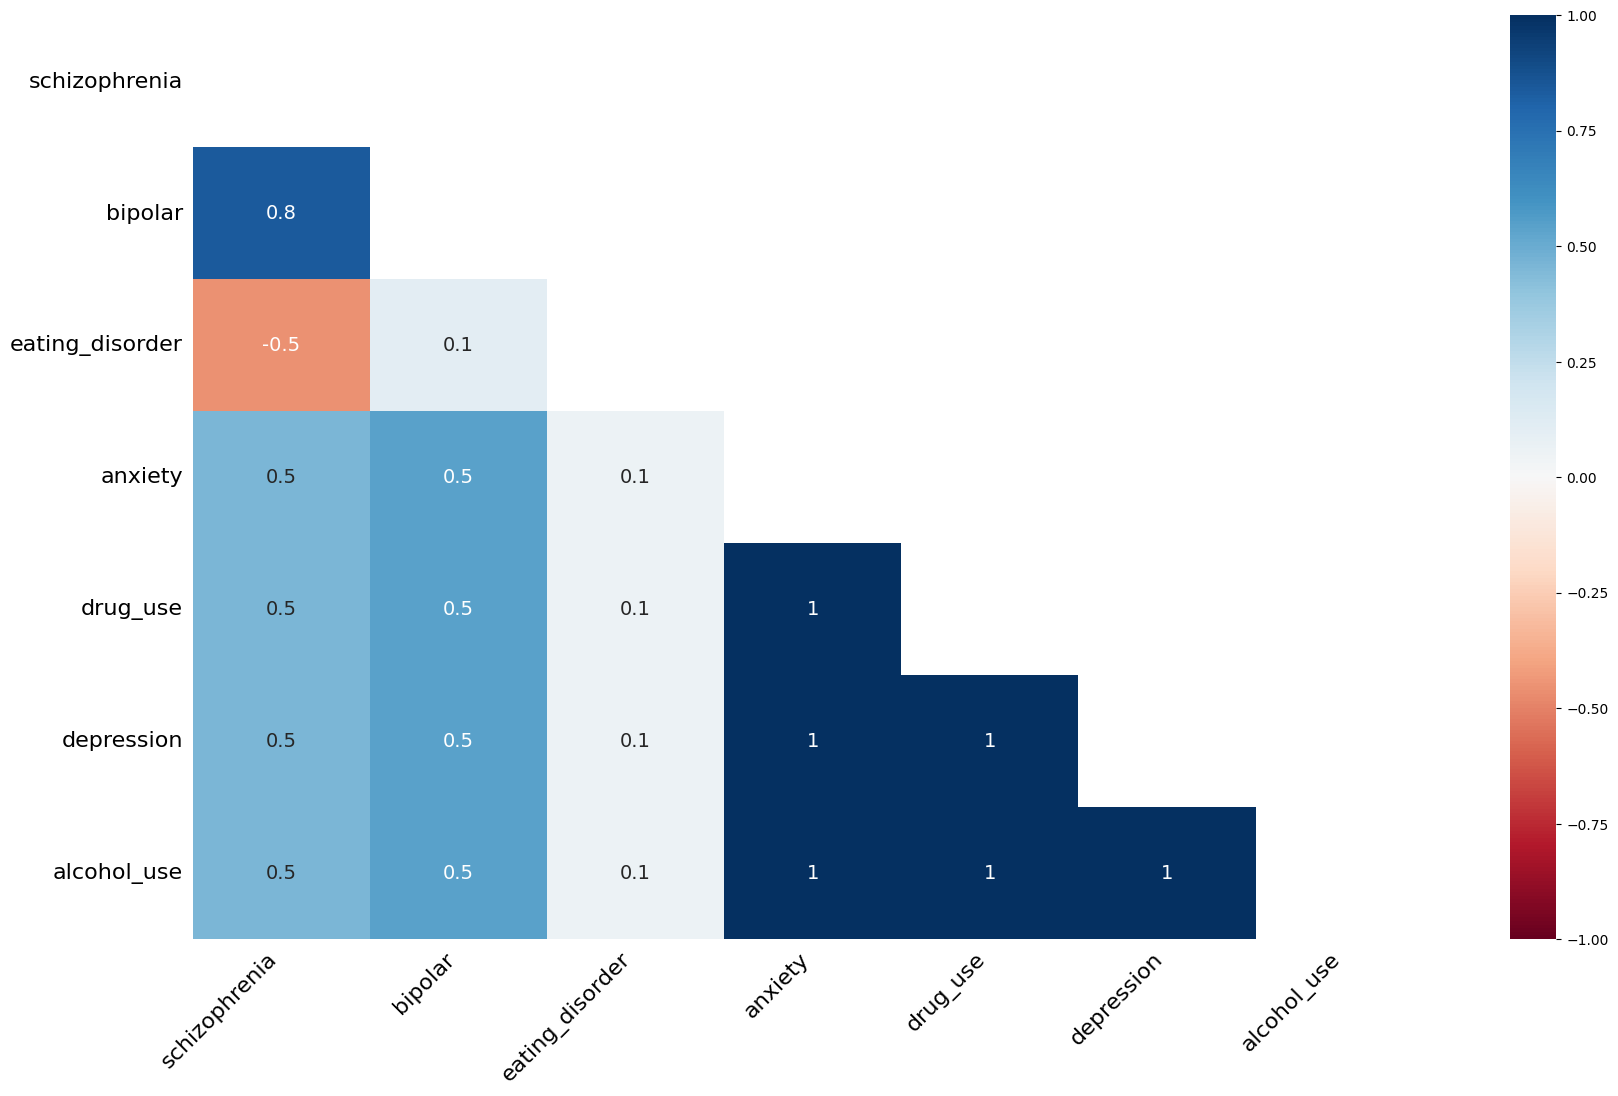

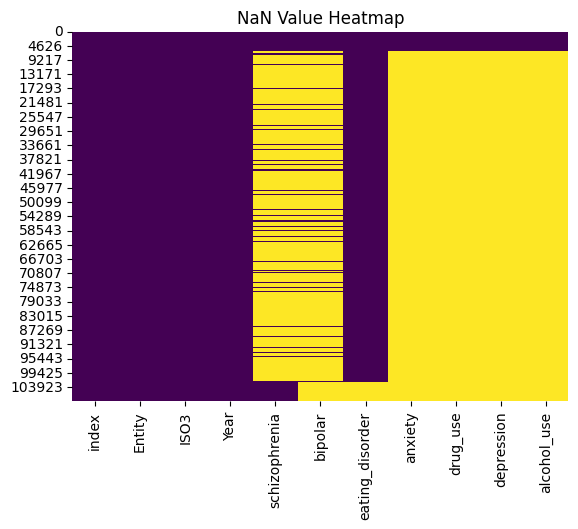

Count of NaN values per column:
index                  0
Entity                 0
ISO3                   0
Year                   0
schizophrenia      80940
bipolar            86400
eating_disorder     5460
anxiety            97320
drug_use           97320
depression         97320
alcohol_use        97320
dtype: int64

Percentage of NaN values per column:
index               0.000000
Entity              0.000000
ISO3                0.000000
Year                0.000000
schizophrenia      78.750730
bipolar            84.063047
eating_disorder     5.312318
anxiety            94.687682
drug_use           94.687682
depression         94.687682
alcohol_use        94.687682
dtype: float64


In [8]:
# Visualize missing data patterns

# Heatmap of missing values correlation (Missingno)
msno.heatmap(mental_health_df)
plt.show()

# Basic heatmap of NaN values (Seaborn)
sns.heatmap(mental_health_df.isna(), cbar=False, cmap='viridis')
plt.title('NaN Value Heatmap')
plt.show()

# Count NaN values per column
print("Count of NaN values per column:")
print(mental_health_df.isna().sum())

# Percentage of NaN values per column
print("\nPercentage of NaN values per column:")
print(mental_health_df.isna().mean() * 100)

In [9]:
# Additional analysis on missing data for eating_disorder, schizophrenia, and 
# dataset excluding eating_disorder and schizophrenia

# eating_disorder: had the least amount of NaN values in the dataset
ed_clean_df = mental_health_df.dropna(subset=['eating_disorder'])
ed_clean_df = ed_clean_df[['ISO3', 'Year', 'eating_disorder']]
print(f"eating_disorder clean dataframe shape: {ed_clean_df.shape}")
print(ed_clean_df.isnull().sum())

# schizophrenia: spitting from the ends and excluding middle values to prevent skews
schiz_df = mental_health_df.dropna(subset=['schizophrenia']).sort_values(by='schizophrenia')
schiz_df = schiz_df[['ISO3', 'Year', 'schizophrenia']]
schiz_first_5k_df = schiz_df.head(5000)
schiz_last_5k_df = schiz_df.tail(5000)
schiz_cleaned_df = pd.concat([schiz_first_5k_df, schiz_last_5k_df], axis=0).reset_index(drop=True)
print(f"schizophrenia first/last 5k dataframe shape: {schiz_cleaned_df.shape}")
print(schiz_cleaned_df.isnull().sum())

# chunk of data frame with no missing values, excluding eating_disorder and schizophrenia
mh_columns_to_keep = ['ISO3', 'Year', 'bipolar', 'anxiety', 'drug_use', 'depression', 'alcohol_use']
mh_clean_df = mental_health_df.drop(columns=['schizophrenia', 'eating_disorder'])
mh_clean_df = mh_clean_df.head(5000)
mh_clean_df = mh_clean_df[mh_columns_to_keep]
print(f"5k rows, mental health disorders (excluding schizophrenia and ED) dataframe shape: {mh_clean_df.shape}")
print(mh_clean_df.isnull().sum())

eating_disorder clean dataframe shape: (97320, 3)
ISO3               0
Year               0
eating_disorder    0
dtype: int64
schizophrenia first/last 5k dataframe shape: (10000, 3)
ISO3             0
Year             0
schizophrenia    0
dtype: int64
5k rows, mental health disorders (excluding schizophrenia and ED) dataframe shape: (5000, 7)
ISO3           0
Year           0
bipolar        0
anxiety        0
drug_use       0
depression     0
alcohol_use    0
dtype: int64


In [10]:
# Analyze missing values in Mental Health Disorders by country
# Explore NaN values by country (ISO3)

# Mental health disorder list
disorders = ['schizophrenia', 'bipolar', 'eating_disorder', 'anxiety', 'drug_use', 'depression', 'alcohol_use']

# Group by country (ISO3) and calculate the number of missing values (NaN) per disorder
# [Count] 
nan_by_iso3 = mental_health_df[disorders].isna().groupby(mental_health_df['ISO3']).sum()
print(nan_by_iso3)
# [Percentage]
nan_pct_by_iso3 = mental_health_df[disorders].isna().groupby(mental_health_df['ISO3']).mean() * 100
print(nan_pct_by_iso3)

      schizophrenia  bipolar  eating_disorder  anxiety  drug_use  depression  \
ISO3                                                                           
ABW             140      140                0      140       140         140   
AFG             384      412               28      468       468         468   
AGO             384      412               28      468       468         468   
AIA             140      140                0      140       140         140   
ALB             384      412               28      468       468         468   
...             ...      ...              ...      ...       ...         ...   
WSM             384      412               28      468       468         468   
YEM             384      412               28      468       468         468   
ZAF             384      412               28      468       468         468   
ZMB             384      412               28      468       468         468   
ZWE             384      412            

In [11]:
# Drop rows with missing values in any of the disorder columns
print(f"Rows BEFORE dropping missing values: {len(mental_health_df)}")

# Drop rows where any of the disorder columns are NaN
nonnull_mental_health_df = mental_health_df.dropna(subset=disorders)
print(f"Rows AFTER dropping missing values: {len(nonnull_mental_health_df)}")

Rows BEFORE dropping missing values: 102780
Rows AFTER dropping missing values: 5460


In [12]:
# Clean Mental Health dataframe
# Convert column types from object to numeric
for column in disorders:
    mental_health_df[column] = pd.to_numeric(mental_health_df[column], errors='coerce')

# Drop unnecessary columns
mental_health_df = mental_health_df.drop(columns=['index'])
mental_health_df

,Entity,ISO3,Year,schizophrenia,bipolar,eating_disorder,anxiety,drug_use,depression,alcohol_use
0,Afghanistan,AFG,1990,0.160560,0.697779,0.101855,4.828830,1.677082,4.071831,0.672404
1,Afghanistan,AFG,1991,0.160312,0.697961,0.099313,4.829740,1.684746,4.079531,0.671768
2,Afghanistan,AFG,1992,0.160135,0.698107,0.096692,4.831108,1.694334,4.088358,0.670644
3,Afghanistan,AFG,1993,0.160037,0.698257,0.094336,4.830864,1.705320,4.096190,0.669738
4,Afghanistan,AFG,1994,0.160022,0.698469,0.092439,4.829423,1.716069,4.099582,0.669260
...,...,...,...,...,...,...,...,...,...,...
108548,Zimbabwe,ZWE,2013,303564.603590,NaN,NaN,NaN,NaN,NaN,NaN
108549,Zimbabwe,ZWE,2014,311665.769283,NaN,NaN,NaN,NaN,NaN,NaN
108550,Zimbabwe,ZWE,2015,320638.507158,NaN,NaN,NaN,NaN,NaN,NaN
108551,Zimbabwe,ZWE,2016,330437.353798,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Process Global Dietary Diversity dataset

# Convert string of factors to a set per row
def parse_factors(factor_str):
    if pd.isna(factor_str):
        return set()
    return set(f.strip() for f in factor_str.strip('{}').split('|'))

# Apply parsing to create per-row sets
gdd_df['factor_set'] = gdd_df['Available dietary factors'].apply(parse_factors)

# Group by ISO3 and Year to union all sets per country-year
factor_union_df = gdd_df.groupby(['ISO3', 'Year'])['factor_set'].apply(lambda sets: set().union(*sets)).reset_index()

# Merge back to original gdd_df and drop the per-row factor_set to avoid conflict
gdd_df = gdd_df.drop(columns=['factor_set', 'Available dietary factors'])

# Merge in the unified factor_set and Diet Category
diet_df = pd.merge(gdd_df, factor_union_df, on=['ISO3', 'Year'], how='left')

diet_df.sample(20)

,ISO3,Year,Youngest age,Oldest age,factor_set
83,CAN,2010,11.00,15.000000,"{Fruits, Sugar-Sweetened Beverages, Non-Starch..."
566,PHL,2003,20.00,100.000000,"{Total Processed Meats, Fruits, Fruit Juice, S..."
311,IRL,2005,13.00,17.000000,"{Calcium, Total Energy, Dietary Fiber, Dietary..."
4,ARE,2003,18.00,90.000000,"{Fruits, Non-Starchy Vegetables}"
416,KOR,1998,1.00,98.000000,"{Total Processed Meats, Fruits, Fruit Juice, P..."
55,BGR,2004,20.00,100.000000,"{Total Processed Meats, Fruits, Fruit Juice, N..."
75,BRB,2011,11.00,16.000000,"{Fruits, Sugar-Sweetened Beverages, Non-Starch..."
113,COD,2013,0.00,59.000000,"{Cheese, Eggs, Fruits, Fruit Juice, Unprocesse..."
296,IDN,2012,0.00,4.000000,"{Cheese, Eggs, Fruits, Fruit Juice, Unprocesse..."
6,ARG,2007,11.00,16.000000,"{Fruits, Non-Starchy Vegetables}"


In [14]:
# Keeping the exploration for historal purposes. 


# vitamins = {'Vitamin A with Supplements', 'Vitamin A without Supplements',
#     'Vitamin B1', 'Vitamin B2', 'Vitamin B3', 'Vitamin B6', 'Vitamin B9',
#     'Vitamin C', 'Vitamin D', 'Vitamin E', 'Calcium', 'Magnesium', 'Potassium',
#     'Iodine', 'Selenium', 'Zinc'}

# # Function to compute vitamin scores
# # vitamin_count = number of distinct vitamins
# # vitamin_coverage = percentage of distinct vitamins, normalized score so we can compare across countries
# def vitamin_score(factors):
#     if not factors:
#         return pd.Series({'vitamin_count': 0, 
#                         'vitamin_coverage': 0,
#                         'has_vitamin': 0})
    
#     vitamin_count = sum(f in vitamins for f in factors)
#     max_vitamin_count = len(vitamins)
#     vitamin_coverage = vitamin_count / max_vitamin_count if max_vitamin_count > 0 else 0.0
#     has_vitamin = 1 if vitamin_count > 0 else 0
    
#     return pd.Series({'vitamin_count': vitamin_count,
#                     'vitamin_coverage': vitamin_coverage,
#                     'has_vitamin': has_vitamin})
    
# diet_df[['vitamin_count', 'vitamin_coverage', 'has_vitamin']] = diet_df['factor_set'].apply(vitamin_score)
# # Apply counting function to your factor sets
# diet_df[['ISO3', 'Year', 'vitamin_count', 'vitamin_coverage', 'has_vitamin']]

In [15]:
# Merge grouped diet data with mental health dataset on ISO3 and Year 
diet_mental_health_df = pd.merge(diet_df, mental_health_df, on=['ISO3', 'Year'])

In [16]:
# Groupings of dietary factors for analysis
plant_based = {
    'Fruits', 'Non-Starchy Vegetables', 'Beans and Legumes', 'Nuts and Seeds',
    'Fruit Juice', 'Dietary Fiber', 'Whole Grains', 'Plant Omega-3 Fat',
    'Plant Protein'
}

animal_based = {
    'Unprocessed Red Meats', 'Total Seafoods', 'Seafood Omega-3 Fat', 'Dietary Cholesterol',
    'Total Milk', 'Cheese', 'Yogurt', 'Eggs', 'Whole Fat Milk', 'Reduced Fat Milk',
    'Total Processed Meats', 'Dairy Protein', 'Animal Protein', 'Total Animal Protein'
}

processed_items = {
    'Added Sugars', 'Sugar-Sweetened Beverages', 'Fruit Juice', 'Refined Grains',
    'Unprocessed Red Meats', 'Total Processed Meats', 'Total Animal Protein',
    'Total Energy', 'Saturated Fat', 'Trans Fatty Acid', 'Dietary Cholesterol',
    'Total Carbohydrates', 'Dairy Protein', 'Whole Fat Milk', 'Reduced Fat Milk',
    'Cheese', 'Glycemic Index', 'Glycemic Load', 'Other Starchy Vegetables',
    'Potatoes', 'Monounsaturated Fat', 'Animal Protein'
}

unprocessed_items = {
    'Fruits', 'Non-Starchy Vegetables', 'Beans and Legumes', 'Nuts and Seeds',
    'Whole Grains', 'Plant Protein', 'Plant Omega-3 Fat', 'Seafood Omega-3 Fat',
    'Dietary Fiber', 'Dietary Sodium', 
    'Total Seafoods', 'Yogurt', 'Eggs', 'Total Protein', 'Coffee', 'Tea'
}

# To score diet diversity
all_items = all_items = processed_items.union(unprocessed_items)

feature_cols = ['plant_based_score', 'animal_based_score', 'processed_diet_score', 'diversity_score']
outcome_cols = ['schizophrenia', 'bipolar', 'eating_disorder', 'anxiety', 'drug_use', 'depression', 'alcohol_use']

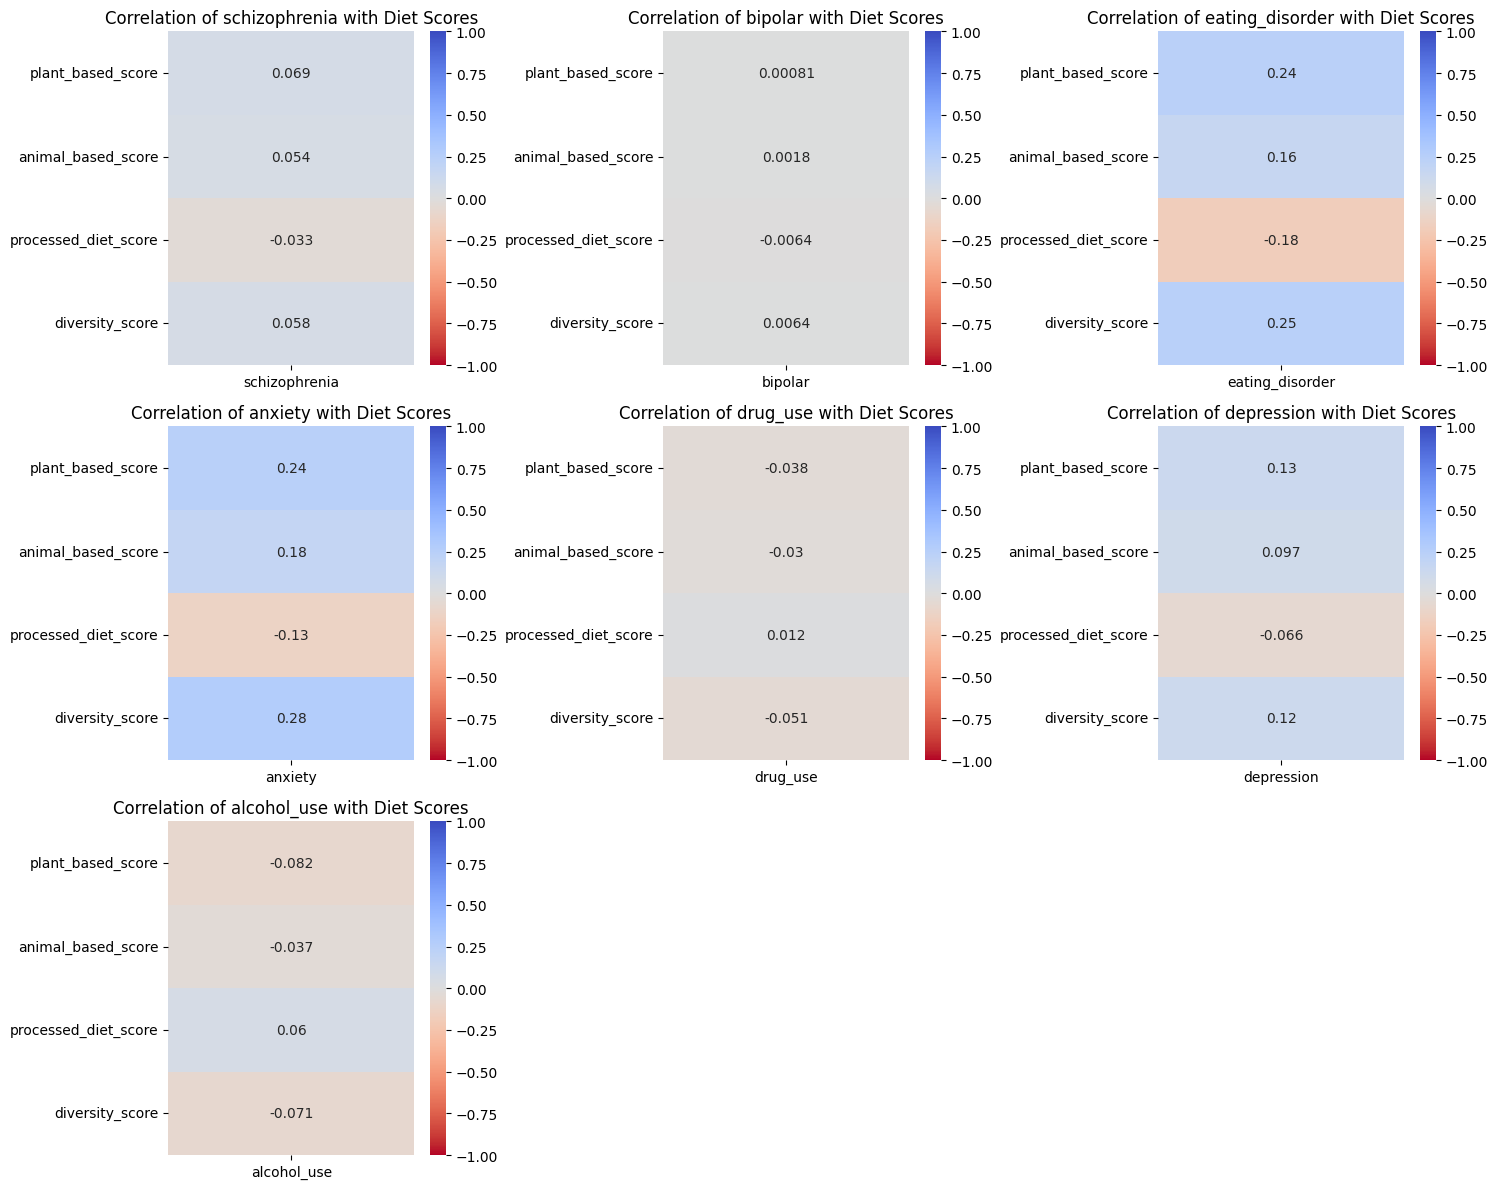

In [17]:
# Correlation matrix for diet_mental_health_df

diet_mental_health_df = scoring.add_diet_scores(diet_mental_health_df, plant_based, animal_based, 'factor_set')
diet_mental_health_df = scoring.compute_processed_diet_score(diet_mental_health_df, 'factor_set', processed_items, unprocessed_items)
diet_mental_health_df = scoring.add_diversity_score(diet_mental_health_df, 'factor_set', all_items)
diet_mental_health_df = analysis.normalize_outcome_columns(diet_mental_health_df)
analysis.plot_outcome_correlations(diet_mental_health_df, outcome_cols, feature_cols)

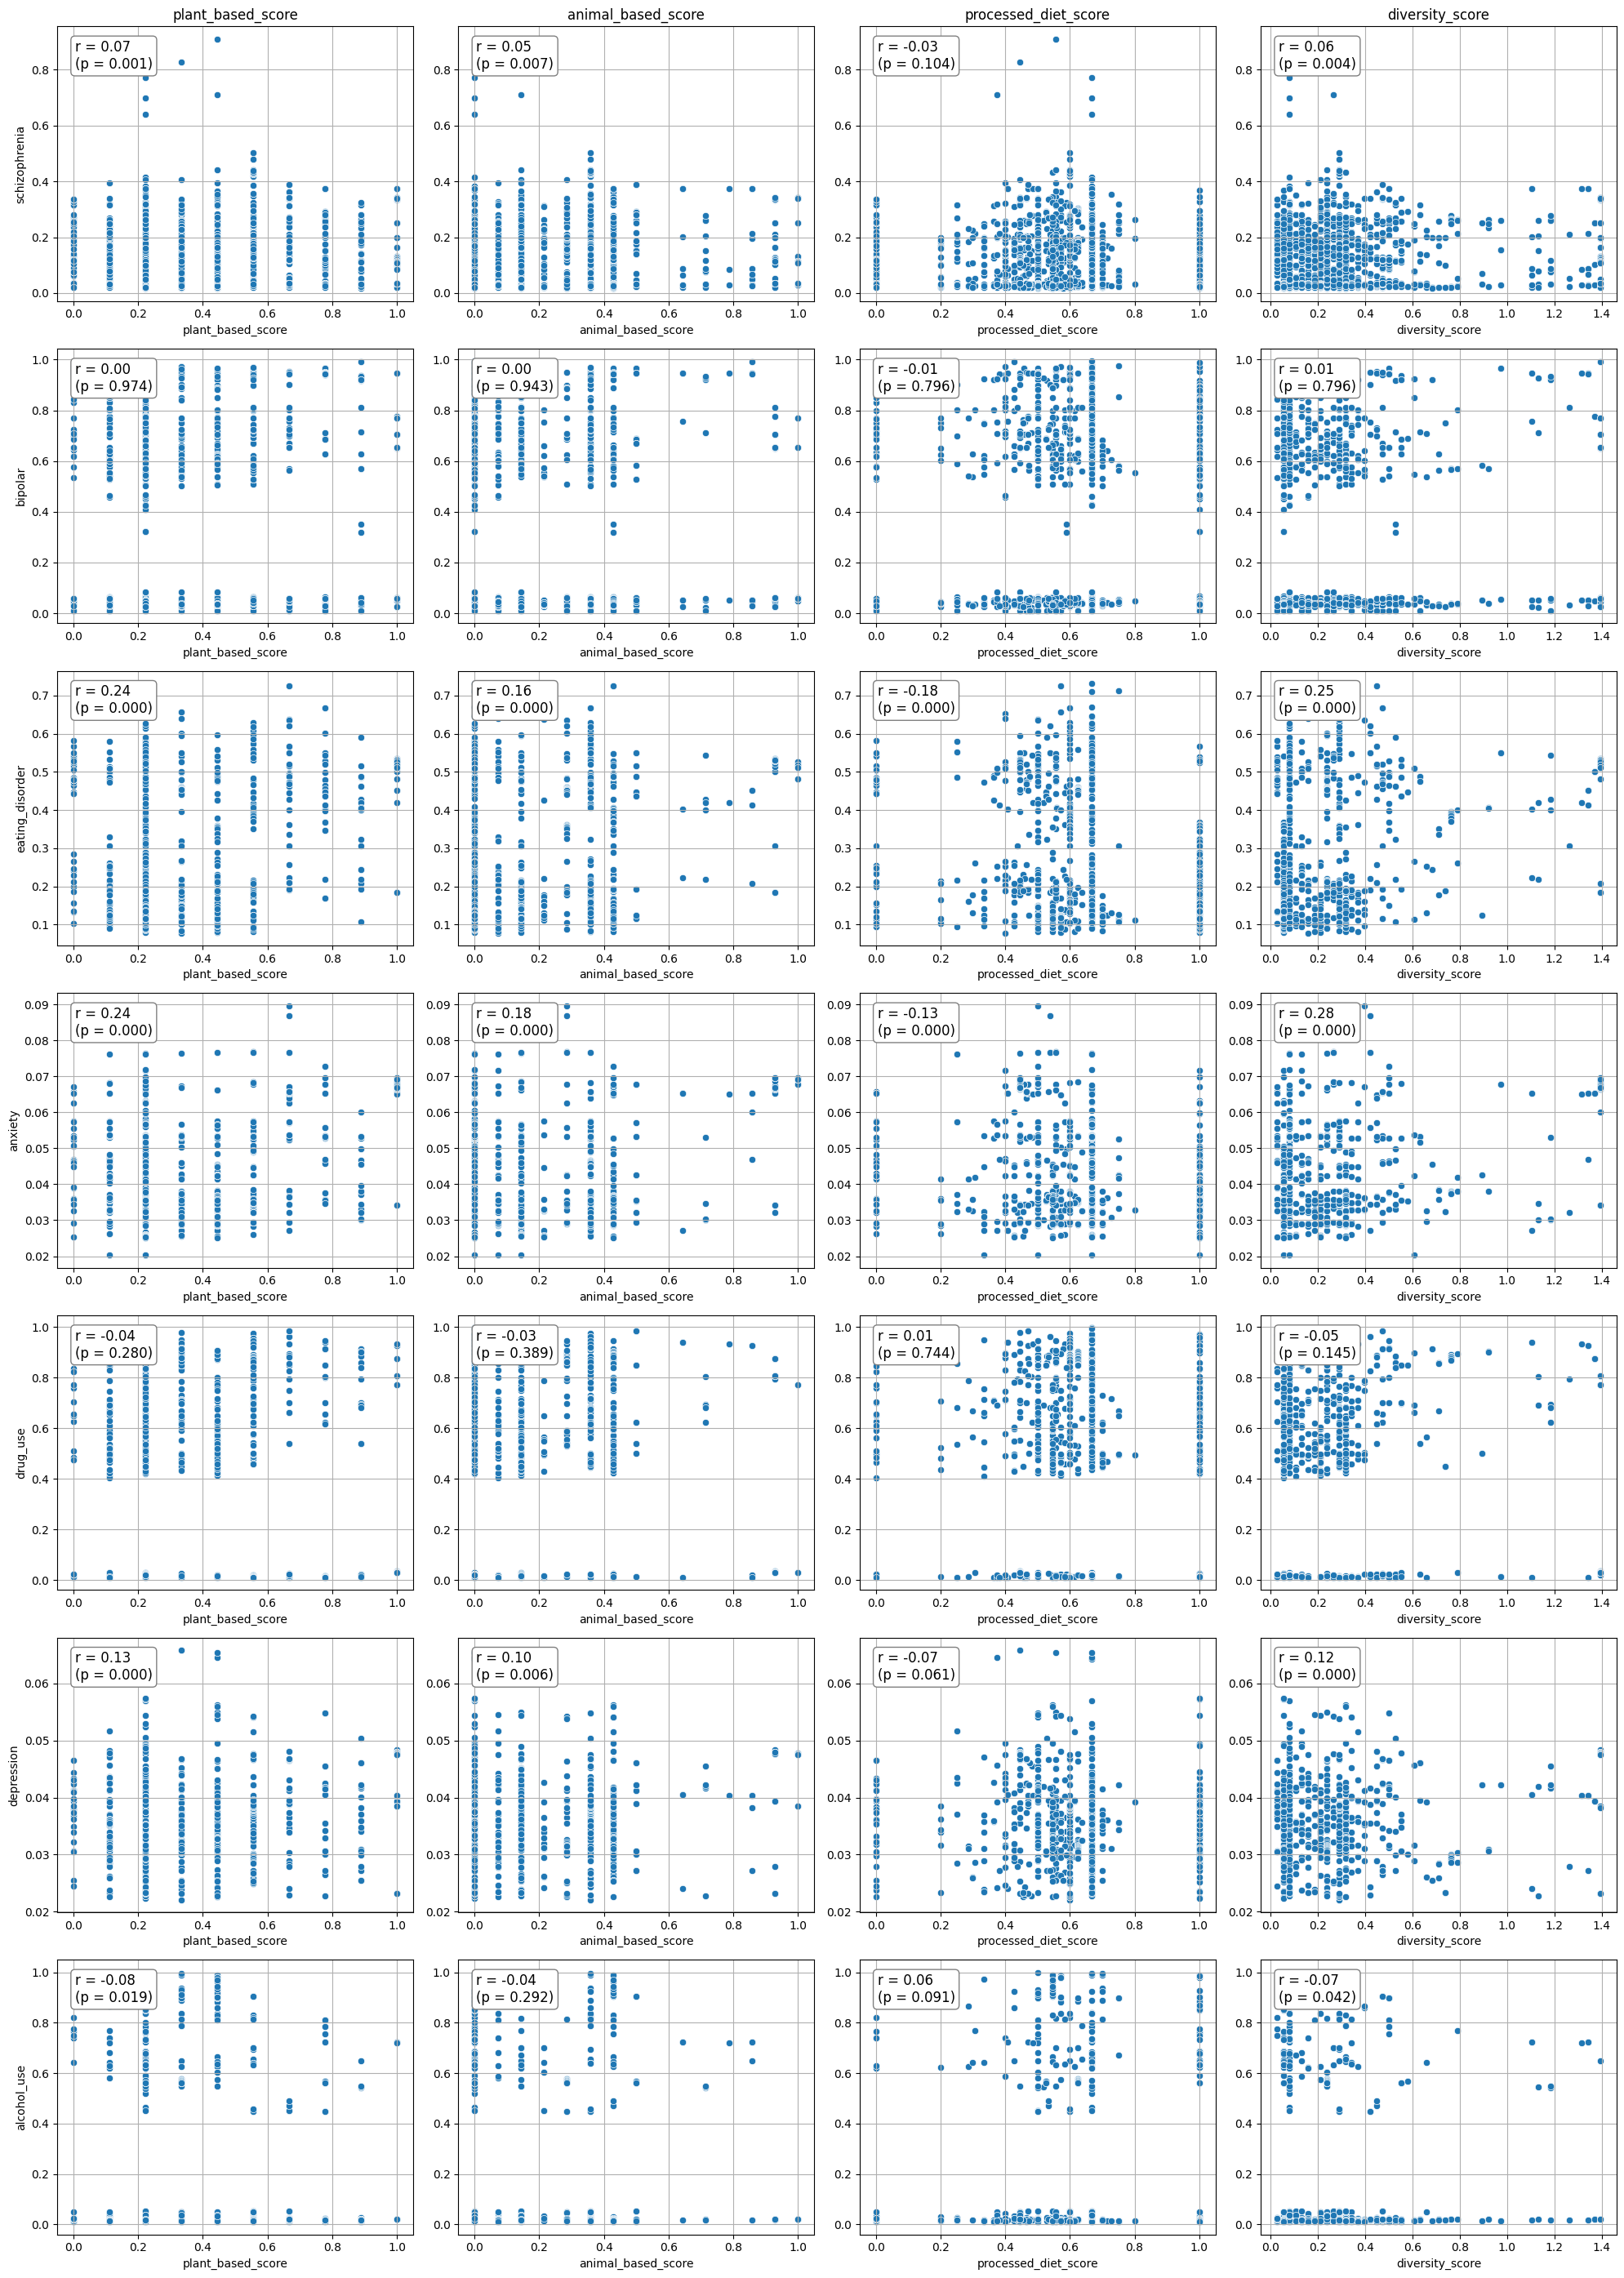

In [18]:
# Scatter plot with correlation for diet_mental_health_df

analysis.plot_scatter_with_correlation(diet_mental_health_df, feature_cols, outcome_cols)

In [19]:
# Splitting up adults and kids

adults_df = diet_mental_health_df[diet_mental_health_df['Oldest age'] >= 18]
kids_df = diet_mental_health_df[diet_mental_health_df['Oldest age'] < 18]

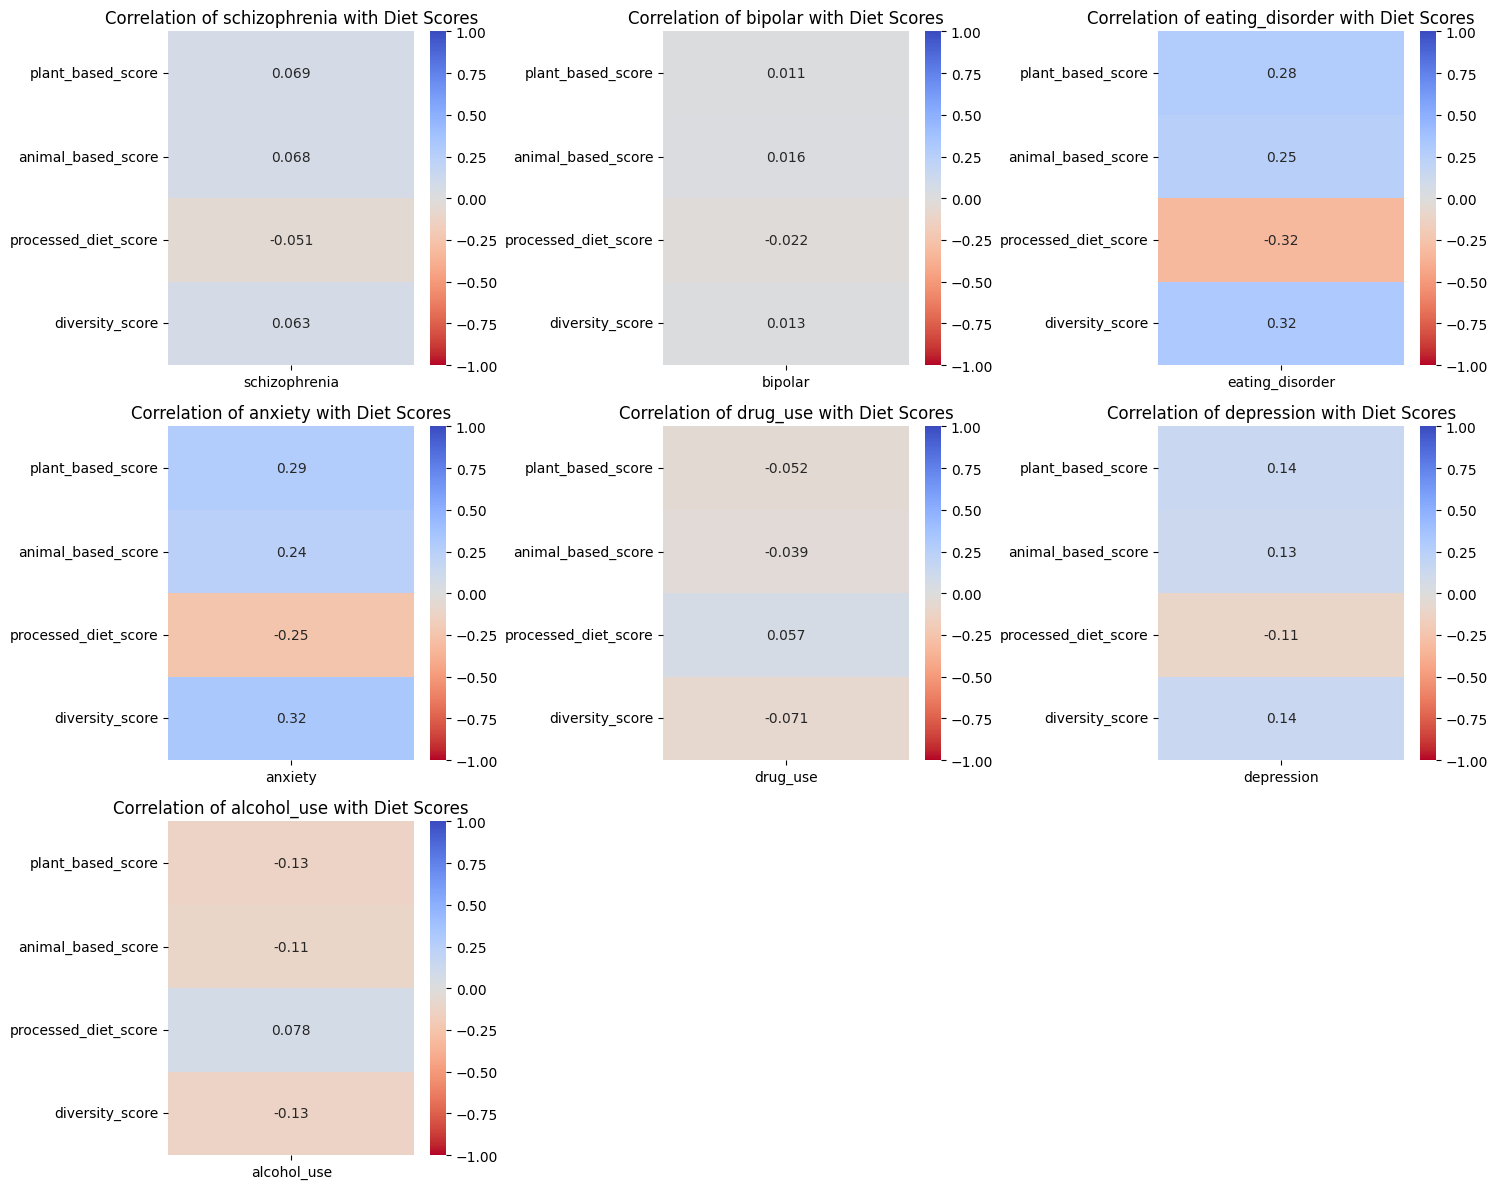

In [20]:
# Correlation matrix for adult_df

adults_df = scoring.add_diet_scores(adults_df, plant_based, animal_based, 'factor_set')
adults_df = scoring.compute_processed_diet_score(adults_df, 'factor_set', processed_items, unprocessed_items)
adults_df = scoring.add_diversity_score(adults_df, 'factor_set', all_items)
adults_df = analysis.normalize_outcome_columns(adults_df)
analysis.plot_outcome_correlations(adults_df, outcome_cols, feature_cols)

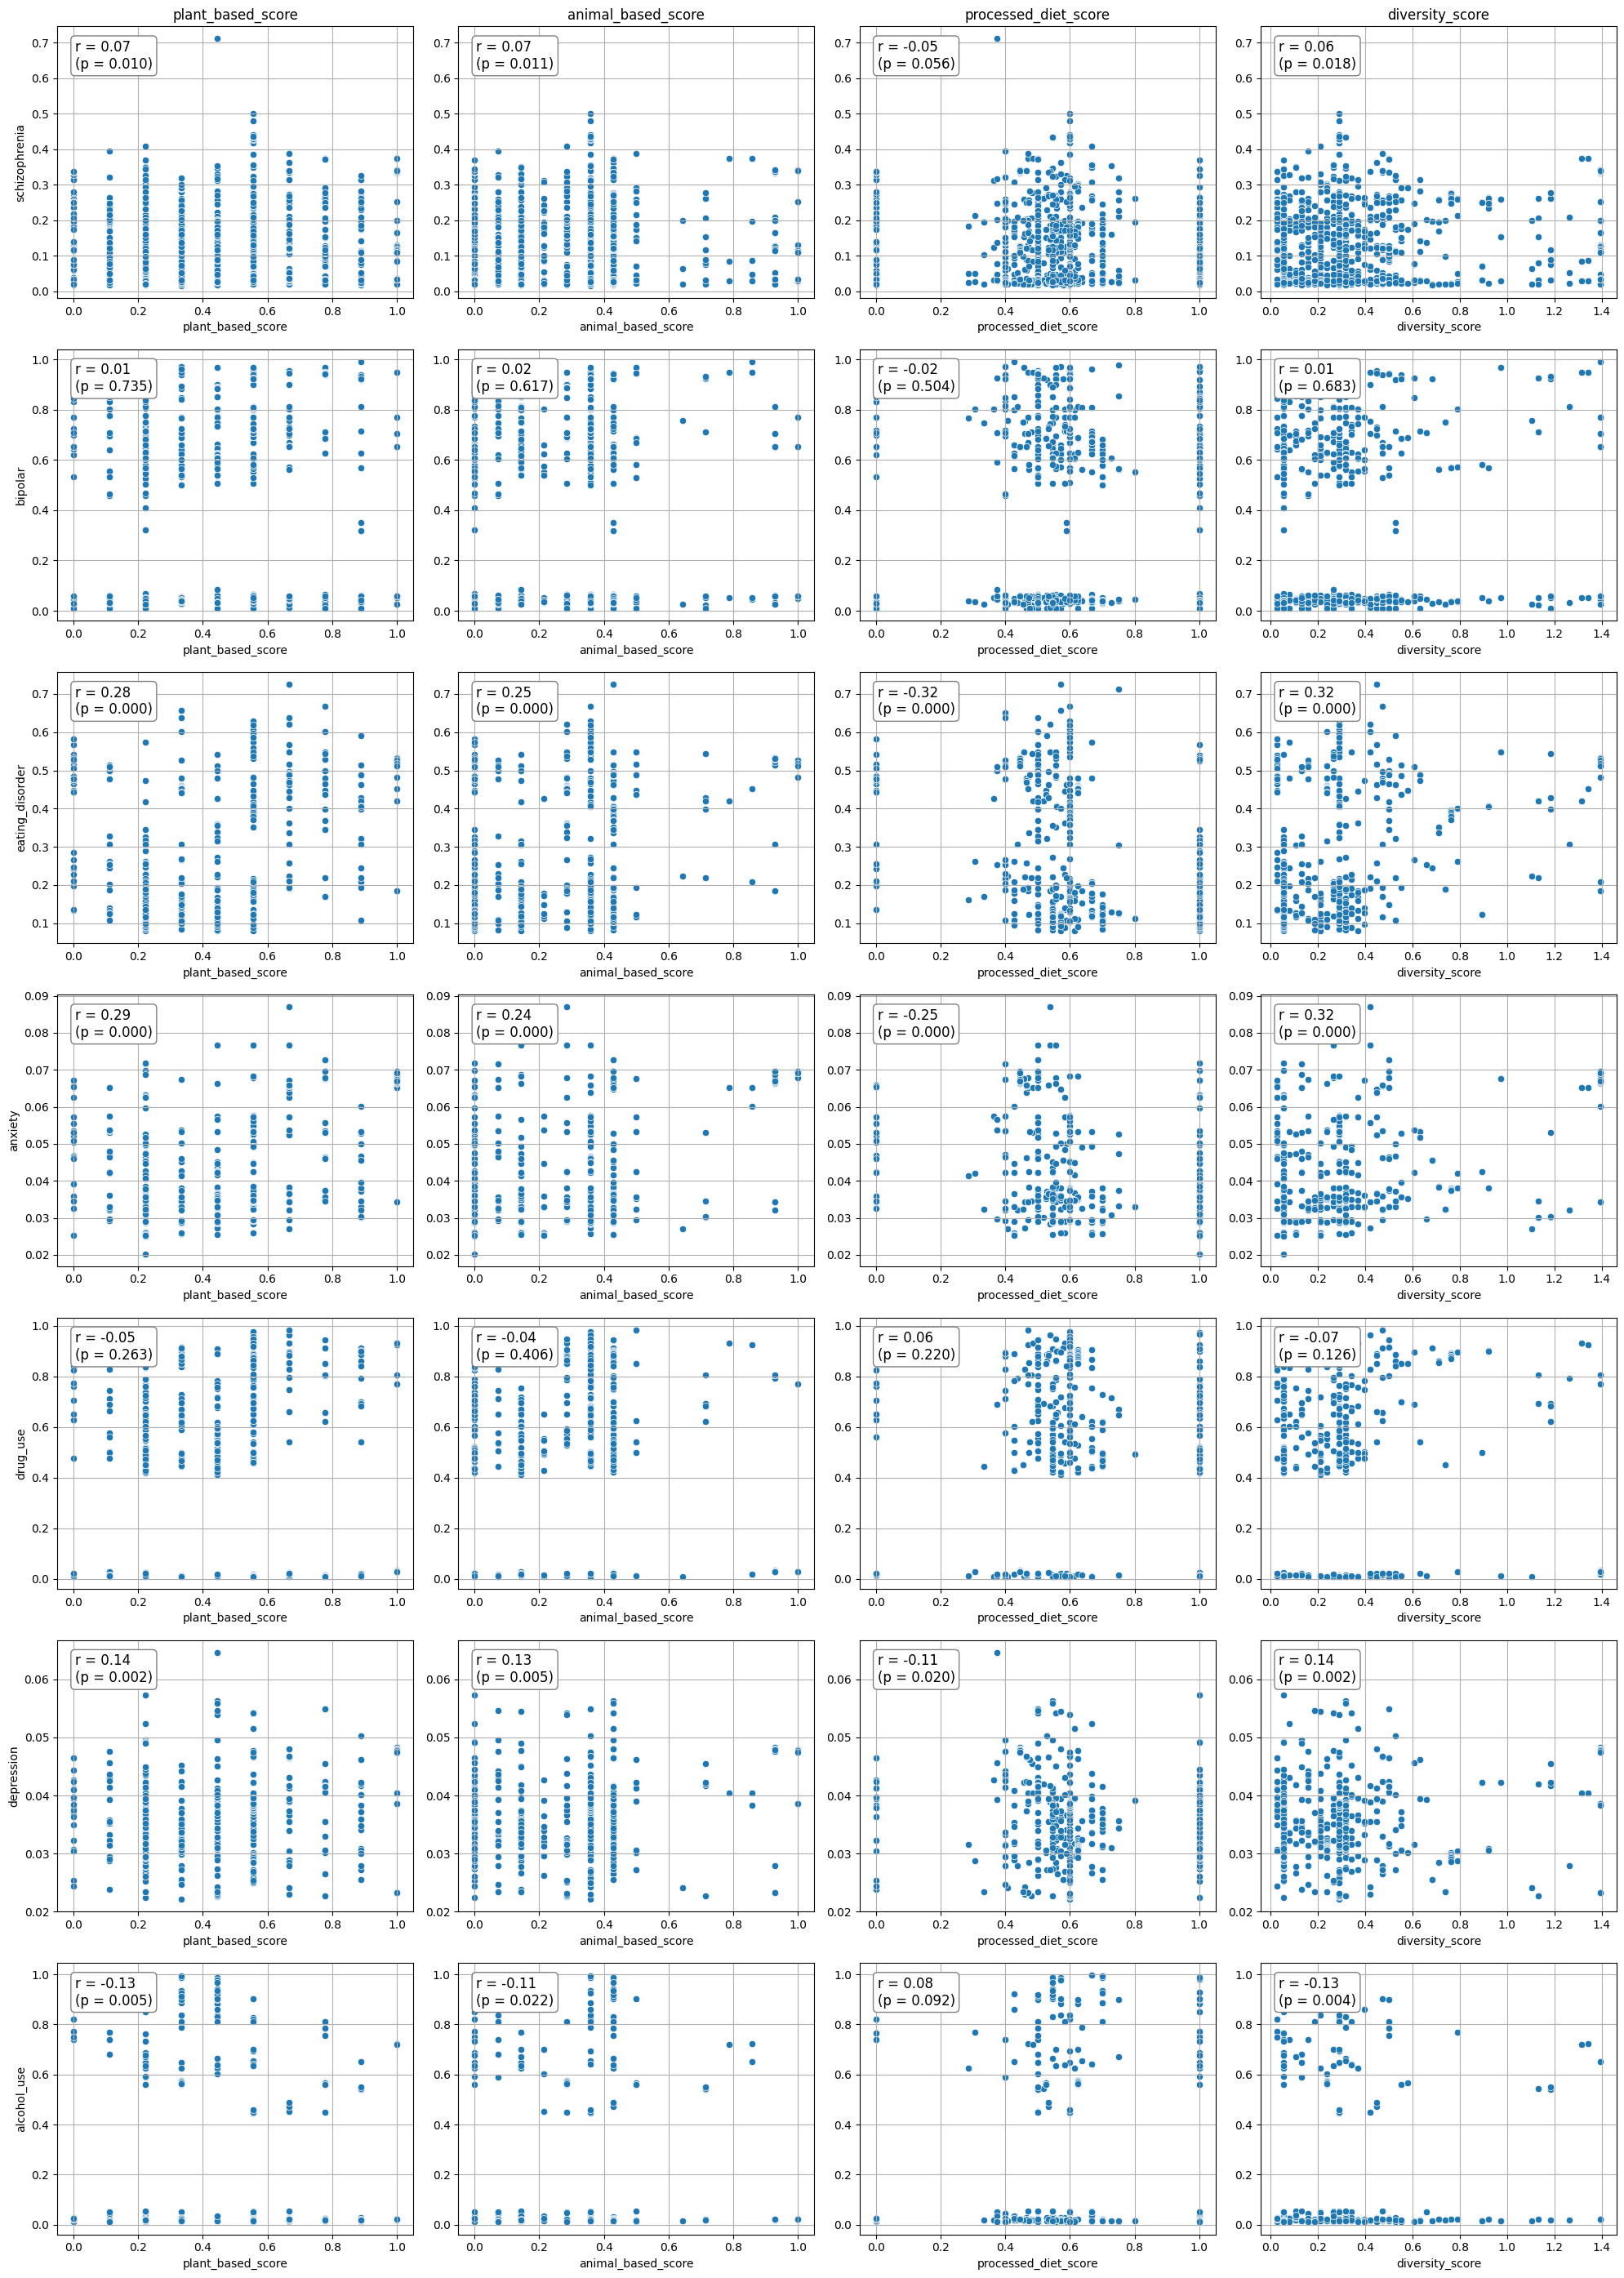

In [21]:
# Scatter plot with correlation for adults_df

analysis.plot_scatter_with_correlation(adults_df, feature_cols, outcome_cols)

In [22]:
# Merging adult dataframe with mental health outcome dataframes

ed_merged_df = pd.merge(diet_df, ed_clean_df, on=['ISO3', 'Year'])
ed_adults_df = ed_merged_df[ed_merged_df['Oldest age'] >= 18]
print(ed_adults_df.columns)

schiz_merged_df = pd.merge(diet_df, schiz_cleaned_df, on=['ISO3', 'Year'])
schiz_adults_df = schiz_merged_df[schiz_merged_df['Oldest age'] >= 18]
print(schiz_adults_df.columns)

mh_clean_merged_df = pd.merge(diet_df, mh_clean_df, on=['ISO3', 'Year'])
mh_adults_df = mh_clean_merged_df[mh_clean_merged_df['Oldest age'] >= 18]
print(mh_adults_df.columns)

Index(['ISO3', 'Year', 'Youngest age', 'Oldest age', 'factor_set',
       'eating_disorder'],
      dtype='object')
Index(['ISO3', 'Year', 'Youngest age', 'Oldest age', 'factor_set',
       'schizophrenia'],
      dtype='object')
Index(['ISO3', 'Year', 'Youngest age', 'Oldest age', 'factor_set', 'bipolar',
       'anxiety', 'drug_use', 'depression', 'alcohol_use'],
      dtype='object')


In [23]:
# Normalizing scores, maintaing rows between 0 to 1
# Skipping columns for dataframes that don't exist

ed_adults_df = analysis.normalize_outcome_columns(ed_adults_df)
schiz_adults_df = analysis.normalize_outcome_columns(schiz_adults_df)
mh_adults_df = analysis.normalize_outcome_columns(mh_adults_df)

schizophrenia not found in dataframe, skipping.
bipolar not found in dataframe, skipping.
anxiety not found in dataframe, skipping.
drug_use not found in dataframe, skipping.
depression not found in dataframe, skipping.
alcohol_use not found in dataframe, skipping.
bipolar not found in dataframe, skipping.
eating_disorder not found in dataframe, skipping.
anxiety not found in dataframe, skipping.
drug_use not found in dataframe, skipping.
depression not found in dataframe, skipping.
alcohol_use not found in dataframe, skipping.
schizophrenia not found in dataframe, skipping.
eating_disorder not found in dataframe, skipping.


In [24]:
# Scorings for eating disorder adult dataframe; dropping duplicate rows

ed_adults_df = scoring.add_diet_scores(ed_adults_df, plant_based, animal_based, 'factor_set')
ed_adults_df = scoring.compute_processed_diet_score(ed_adults_df, 'factor_set', processed_items, unprocessed_items)
ed_adults_df = scoring.add_diversity_score(ed_adults_df, 'factor_set', all_items)
ed_adults_df.drop_duplicates(["ISO3", "Year"], inplace = True)
ed_adults_df

,ISO3,Year,Youngest age,Oldest age,factor_set,eating_disorder,plant_based_score,animal_based_score,processed_count,unprocessed_count,processed_diet_score,diversity_score
0,ALB,2008,0.00,98.0,"{Cheese, Eggs, Fruits, Unprocessed Red Meats, ...",0.154945,0.333333,0.357143,4,6,0.600000,0.289474
6,ARE,2009,6.00,50.0,"{Selenium, Monounsaturated Fat, Vitamin B6, Po...",0.262274,0.111111,0.142857,9,4,0.307692,0.789474
12,ARE,2003,18.00,90.0,"{Fruits, Non-Starchy Vegetables}",0.289831,0.222222,0.000000,0,2,1.000000,0.052632
21,ARG,2004,20.00,49.0,"{Total Processed Meats, Fruits, Unprocessed Re...",0.362547,0.666667,0.285714,5,7,0.583333,0.368421
27,ARM,2005,0.00,49.0,"{Cheese, Eggs, Fruits, Fruit Juice, Unprocesse...",0.135408,0.555556,0.357143,5,7,0.583333,0.342105
...,...,...,...,...,...,...,...,...,...,...,...,...
2390,KOR,2017,0.60,80.0,"{Monounsaturated Fat, Potassium, Seafood Omega...",0.417103,0.222222,0.142857,5,5,0.500000,0.500000
2393,LAO,2016,0.25,89.0,"{Potassium, Vitamin A without Supplements, Tot...",0.125113,0.111111,0.000000,2,2,0.500000,0.342105
2403,PRT,2015,0.25,84.0,"{Zinc, Vitamin B3, Calcium, Dietary Fiber, Tra...",0.510327,0.111111,0.000000,5,3,0.375000,0.605263
2409,ROU,2012,3.00,18.0,"{Selenium, Zinc, Total Omega-6 Fatty Acids, Vi...",0.188991,0.222222,0.142857,6,5,0.454545,0.736842


In [25]:
# Scorings for schizophrenia adult dataframe; dropping duplicate rows

schiz_adults_df = scoring.add_diet_scores(schiz_adults_df, plant_based, animal_based, 'factor_set')
schiz_adults_df = scoring.compute_processed_diet_score(schiz_adults_df, 'factor_set', processed_items, unprocessed_items)
schiz_adults_df = scoring.add_diversity_score(schiz_adults_df, 'factor_set', all_items)
schiz_adults_df.drop_duplicates(["ISO3", "Year"], inplace = True)
schiz_adults_df

,ISO3,Year,Youngest age,Oldest age,factor_set,schizophrenia,plant_based_score,animal_based_score,processed_count,unprocessed_count,processed_diet_score,diversity_score
0,ALB,2008,0.00,98.0,"{Cheese, Eggs, Fruits, Unprocessed Red Meats, ...",0.198306,0.333333,0.357143,4,6,0.600000,0.289474
5,ARE,2009,6.00,50.0,"{Selenium, Monounsaturated Fat, Vitamin B6, Po...",0.213088,0.111111,0.142857,9,4,0.307692,0.789474
9,ARE,2003,18.00,90.0,"{Fruits, Non-Starchy Vegetables}",0.210353,0.222222,0.000000,0,2,1.000000,0.052632
13,ARG,2004,20.00,49.0,"{Total Processed Meats, Fruits, Unprocessed Re...",0.196537,0.666667,0.285714,5,7,0.583333,0.368421
17,ARM,2005,0.00,49.0,"{Cheese, Eggs, Fruits, Fruit Juice, Unprocesse...",0.191950,0.555556,0.357143,5,7,0.583333,0.342105
...,...,...,...,...,...,...,...,...,...,...,...,...
1341,KEN,2011,0.50,49.0,"{Vitamin B6, Vitamin A without Supplements, To...",0.169296,0.111111,0.000000,2,2,0.500000,0.394737
1342,LAO,2016,0.25,89.0,"{Potassium, Vitamin A without Supplements, Tot...",0.215194,0.111111,0.000000,2,2,0.500000,0.342105
1346,PRT,2015,0.25,84.0,"{Zinc, Vitamin B3, Calcium, Dietary Fiber, Tra...",0.249004,0.111111,0.000000,5,3,0.375000,0.605263
1352,ROU,2012,3.00,18.0,"{Selenium, Zinc, Total Omega-6 Fatty Acids, Vi...",0.199097,0.222222,0.142857,6,5,0.454545,0.736842


In [26]:
# Scorings for all mental health adult dataframe; dropping duplicate rows

mh_adults_df = scoring.add_diet_scores(mh_adults_df, plant_based, animal_based, 'factor_set')
mh_adults_df = scoring.compute_processed_diet_score(mh_adults_df, 'factor_set', processed_items, unprocessed_items)
mh_adults_df = scoring.add_diversity_score(mh_adults_df, 'factor_set', all_items)
mh_adults_df.drop_duplicates(["ISO3", "Year"], inplace = True)
mh_adults_df

,ISO3,Year,Youngest age,Oldest age,factor_set,bipolar,anxiety,drug_use,depression,alcohol_use,plant_based_score,animal_based_score,processed_count,unprocessed_count,processed_diet_score,diversity_score
0,ALB,2008,0.00,98.0,"{Cheese, Eggs, Fruits, Unprocessed Red Meats, ...",0.702400,0.033902,0.497332,0.022106,0.017986,0.333333,0.357143,4,6,0.600000,0.289474
3,ARG,2004,20.00,49.0,"{Total Processed Meats, Fruits, Unprocessed Re...",0.769343,0.062562,0.932659,0.036570,0.022541,0.666667,0.285714,5,7,0.583333,0.368421
5,ARM,2005,0.00,49.0,"{Cheese, Eggs, Fruits, Fruit Juice, Unprocesse...",0.714894,0.025917,0.458584,0.026926,0.019270,0.555556,0.357143,5,7,0.583333,0.342105
6,ARM,2001,18.00,99.0,"{Unprocessed Red Meats, Total Milk, Fruits, No...",0.713487,0.025872,0.446004,0.026579,0.020510,0.222222,0.142857,1,2,0.666667,0.105263
8,AUS,1995,0.00,100.0,"{Total Processed Meats, Fruits, Unprocessed Re...",0.011421,0.064785,0.023289,0.048041,0.015063,0.666667,0.428571,6,8,0.571429,0.447368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,KOR,2017,0.60,80.0,"{Monounsaturated Fat, Potassium, Seafood Omega...",0.569459,0.037780,0.914319,0.031657,0.020200,0.222222,0.142857,5,5,0.500000,0.500000
707,LAO,2016,0.25,89.0,"{Potassium, Vitamin A without Supplements, Tot...",0.532987,0.042200,0.662512,0.029003,0.918383,0.111111,0.000000,2,2,0.500000,0.342105
709,PRT,2015,0.25,84.0,"{Zinc, Vitamin B3, Calcium, Dietary Fiber, Tra...",0.925073,0.053791,0.690379,0.045614,0.012765,0.111111,0.000000,5,3,0.375000,0.605263
711,ROU,2012,3.00,18.0,"{Selenium, Zinc, Total Omega-6 Fatty Acids, Vi...",0.750322,0.032348,0.450247,0.023343,0.017142,0.222222,0.142857,6,5,0.454545,0.736842


In [27]:
# Keeping for historical purposes. Code was used to analyze data and decide how to normalize the datasets. 

# def print_column_ranges(df):
    
#     outcome_cols = ['schizophrenia', 'bipolar', 'eating_disorder', 'anxiety', 'drug_use', 'depression', 'alcohol_use']
#     for col in outcome_cols:
#         try:
#             # Attempt to convert column to numeric (ignore errors for non-numeric columns)
#             col_data = pd.to_numeric(df[col], errors='coerce')
#             max_val = col_data.max()
#             min_val = col_data.min()
#             print(f"{col}: {max_val} to {min_val}")
#         except Exception as e:
#             # In case anything unexpected happens
#             print(f"{col}: Error processing column ({e})")

# # mental_health_df
# print_column_ranges(ed_adults_df)
# print_column_ranges(schiz_adults_df)
# print_column_ranges(mh_adults_df)

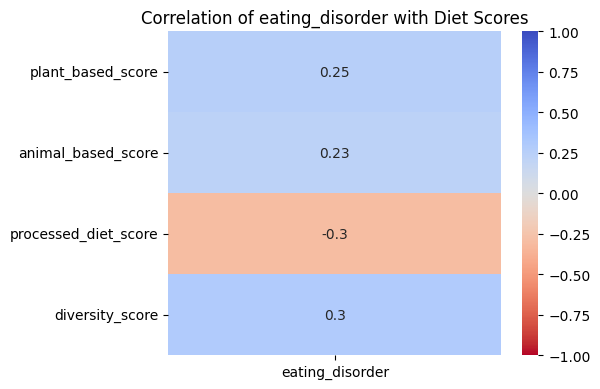

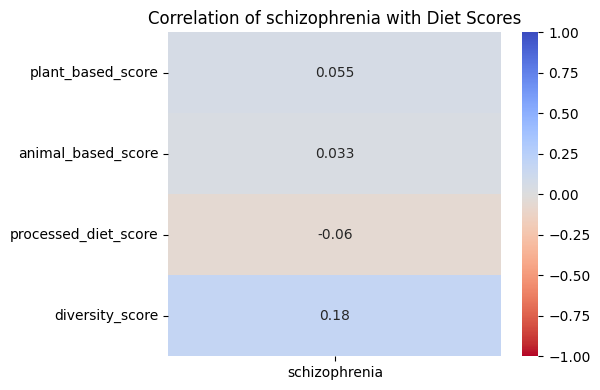

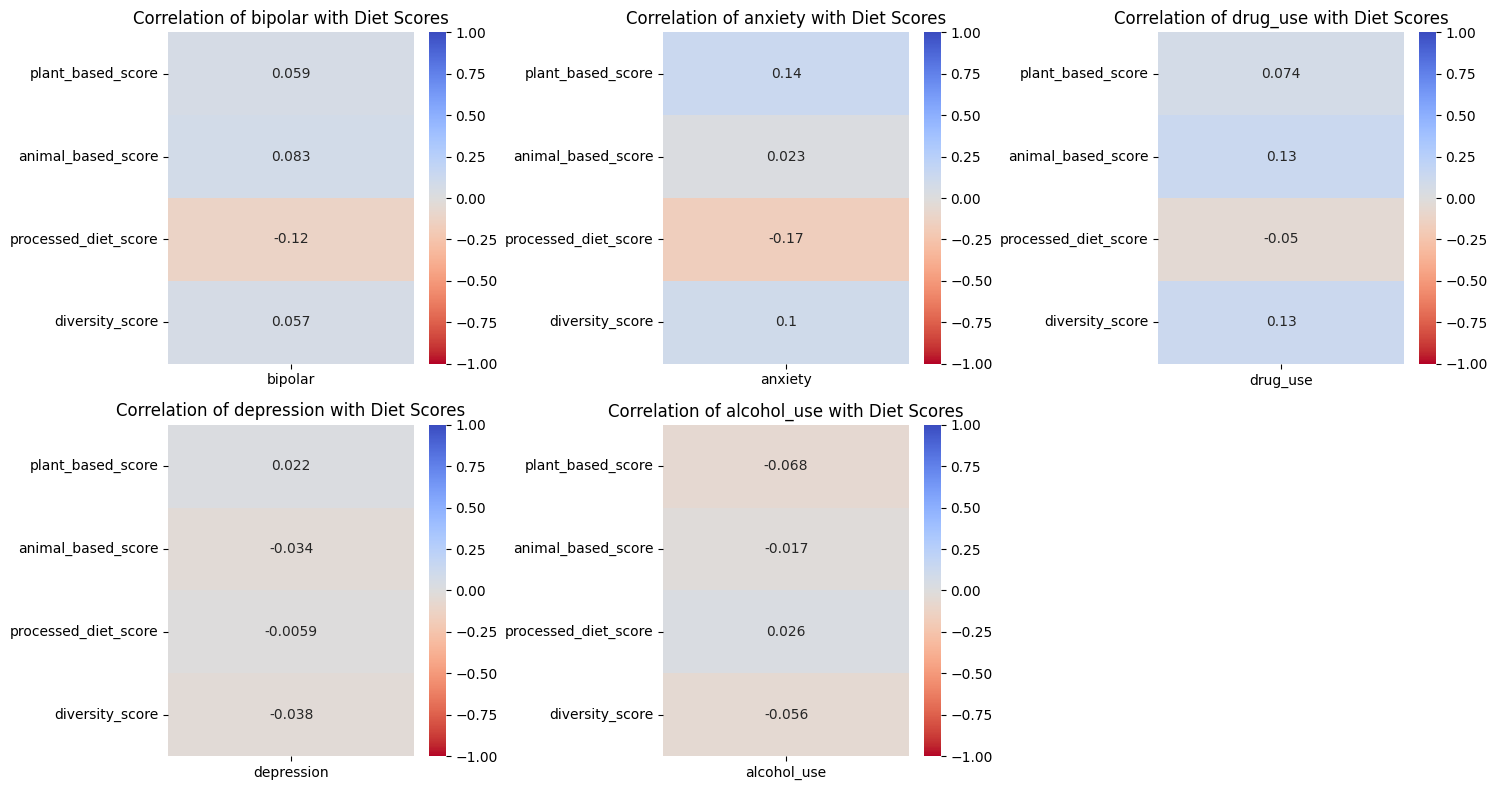

In [28]:
# Correlation matrices
analysis.plot_outcome_correlations(ed_adults_df, outcome_cols, feature_cols)
analysis.plot_outcome_correlations(schiz_adults_df, outcome_cols, feature_cols)
analysis.plot_outcome_correlations(mh_adults_df, outcome_cols, feature_cols)

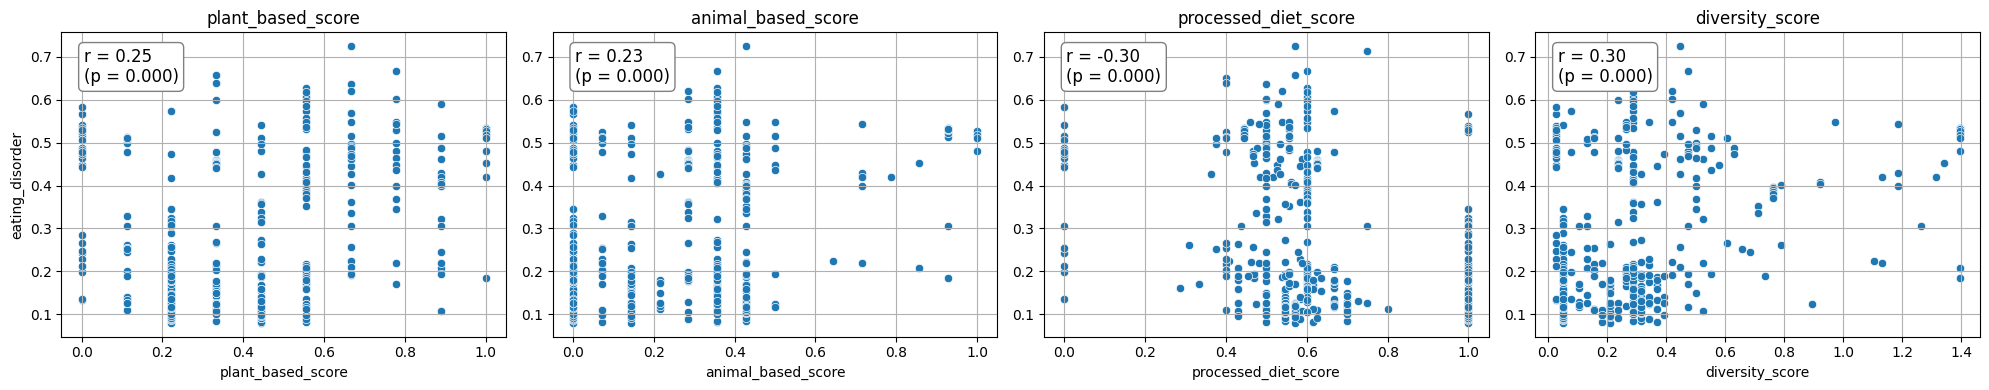

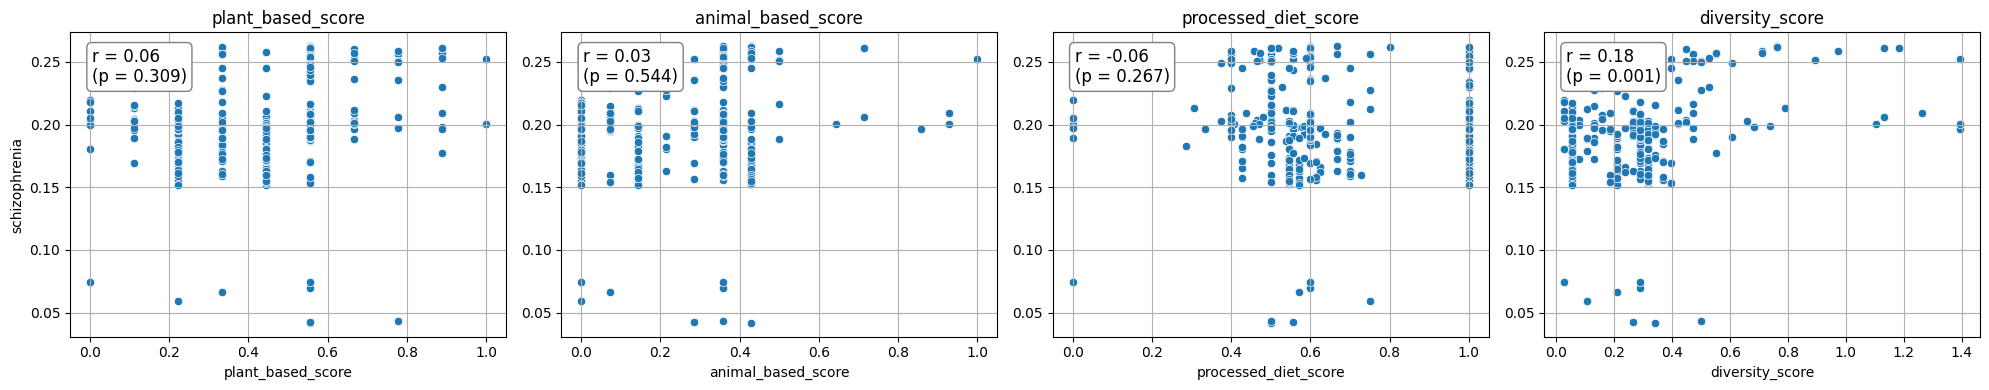

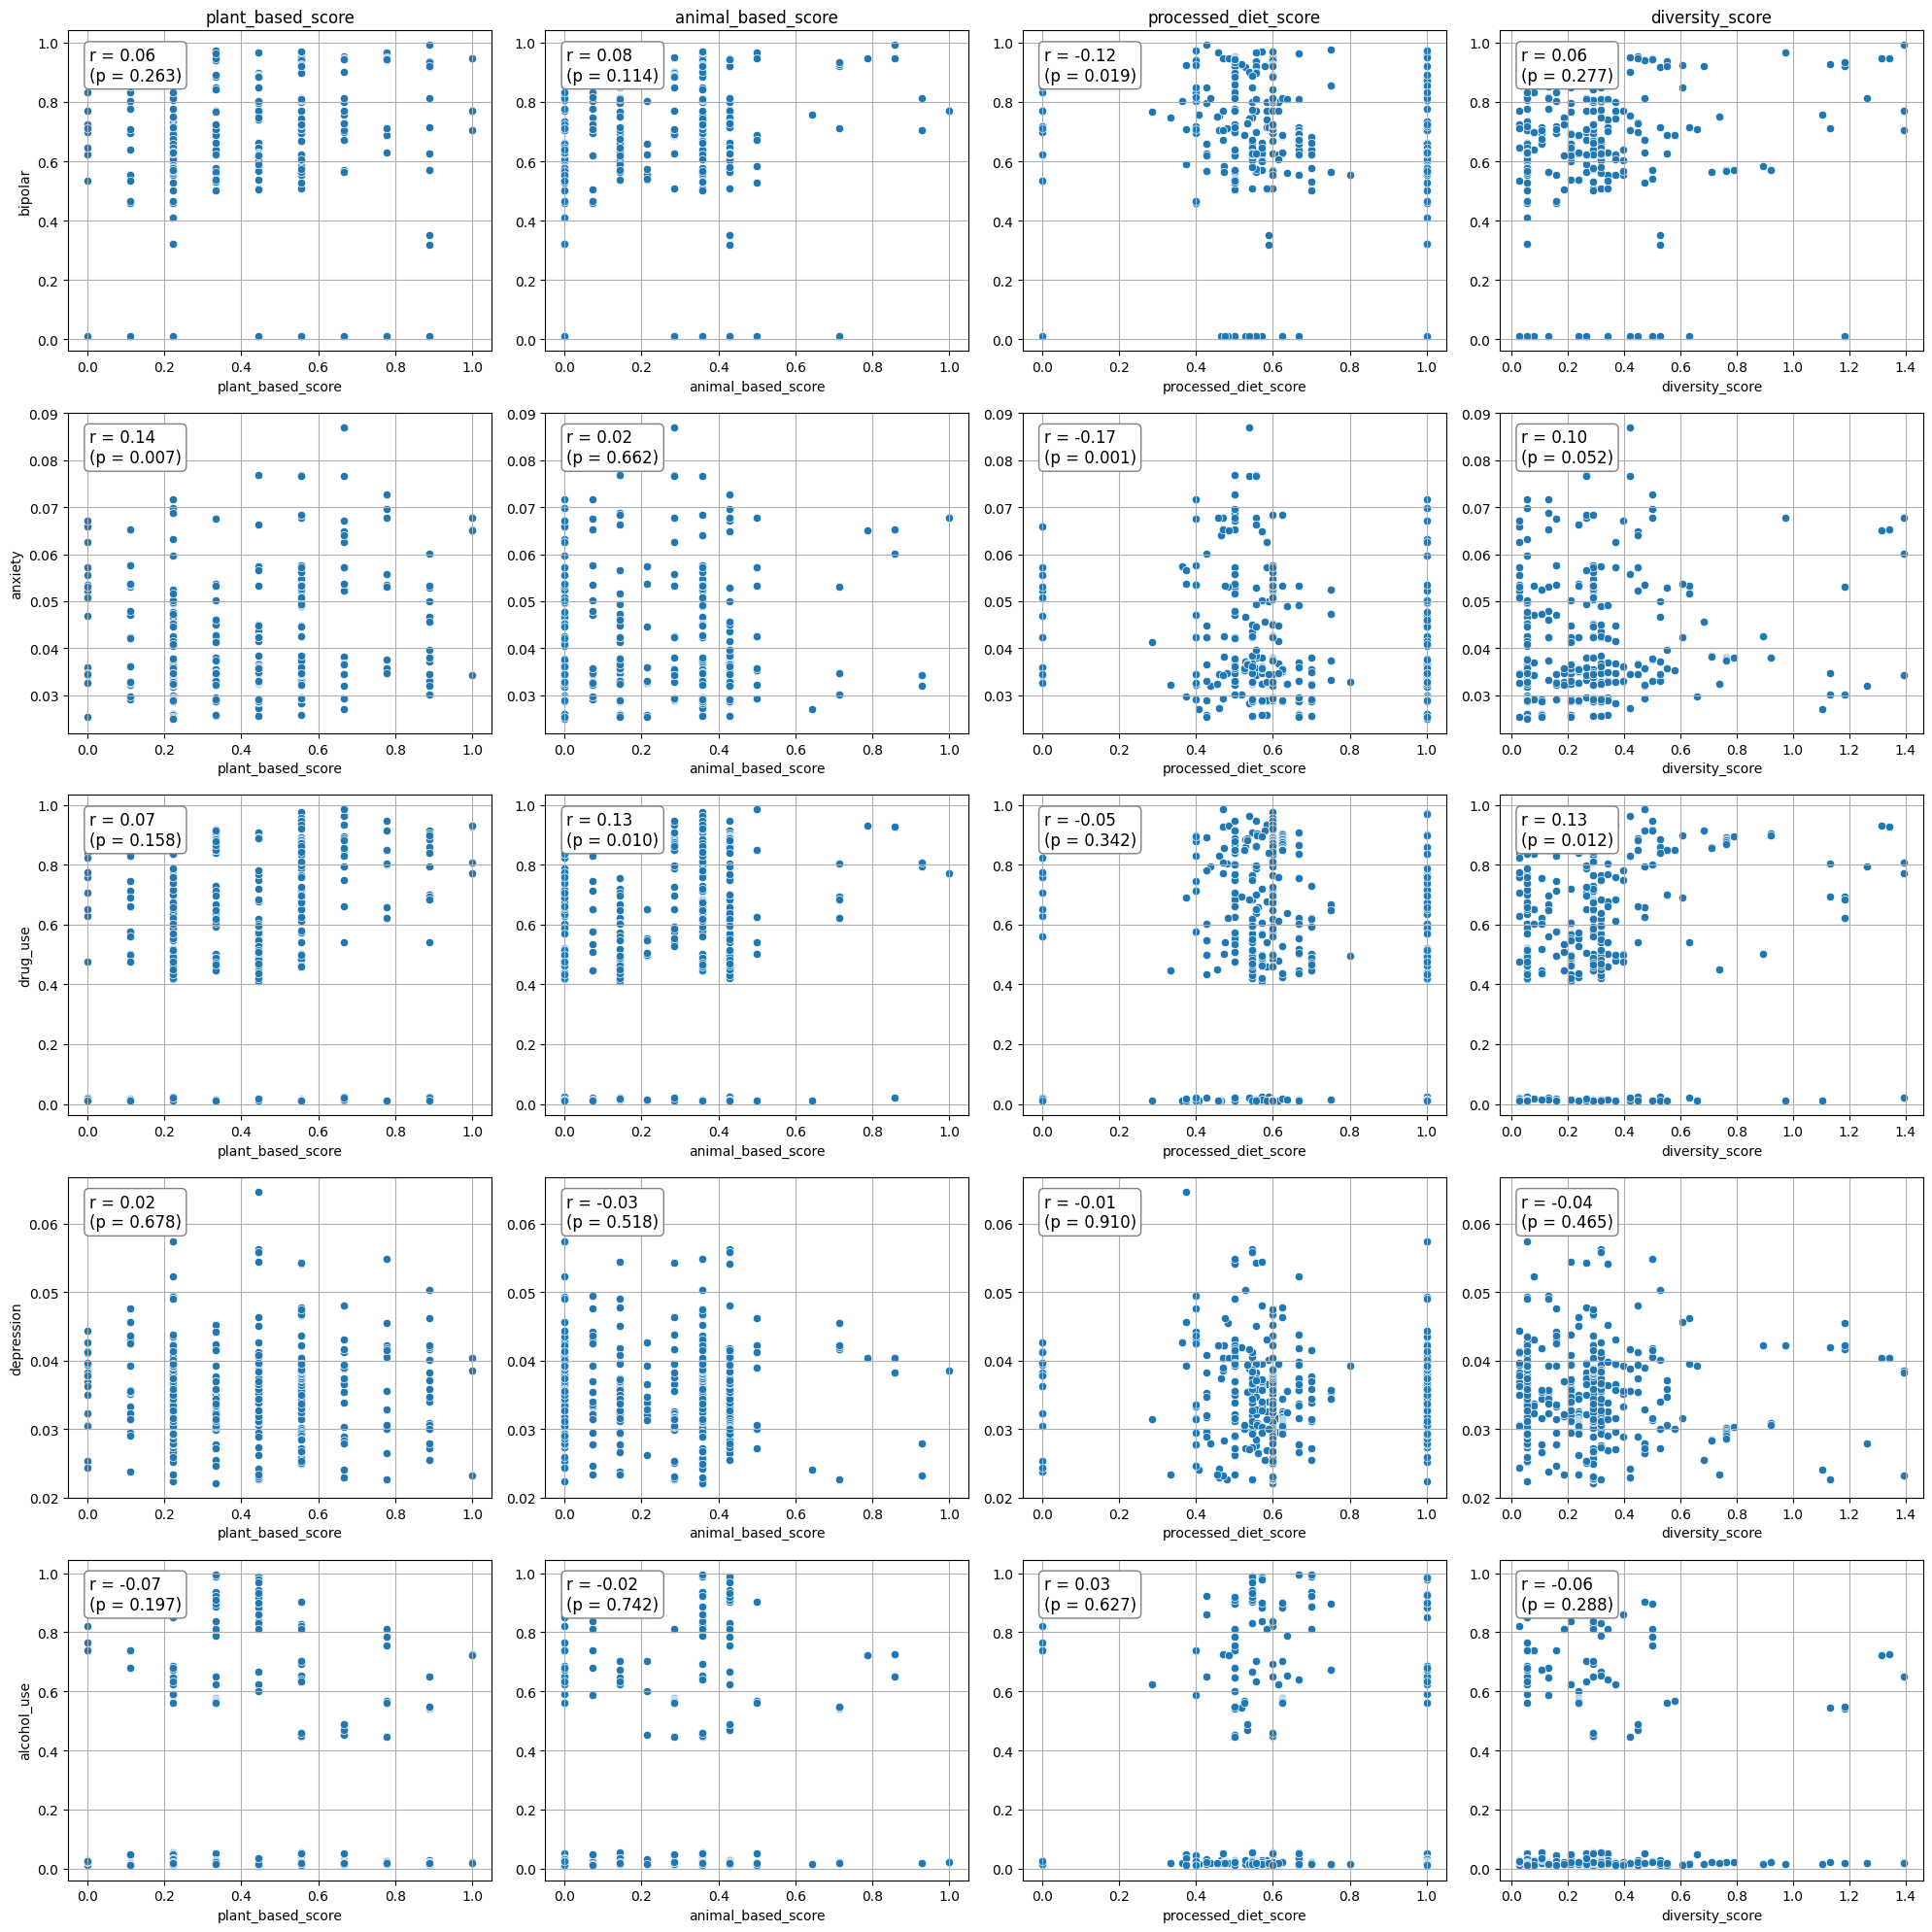

In [29]:
# Scatter plot with correlation
analysis.plot_scatter_with_correlation(ed_adults_df, feature_cols, outcome_cols)
analysis.plot_scatter_with_correlation(schiz_adults_df, feature_cols, outcome_cols)
analysis.plot_scatter_with_correlation(mh_adults_df, feature_cols, outcome_cols)

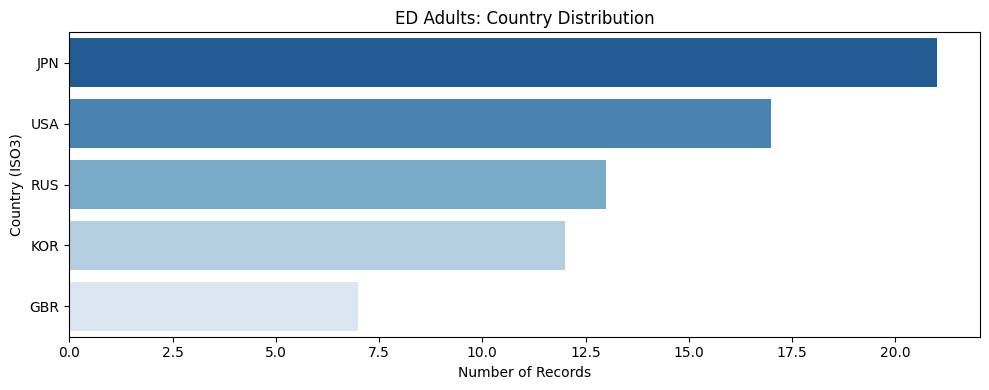

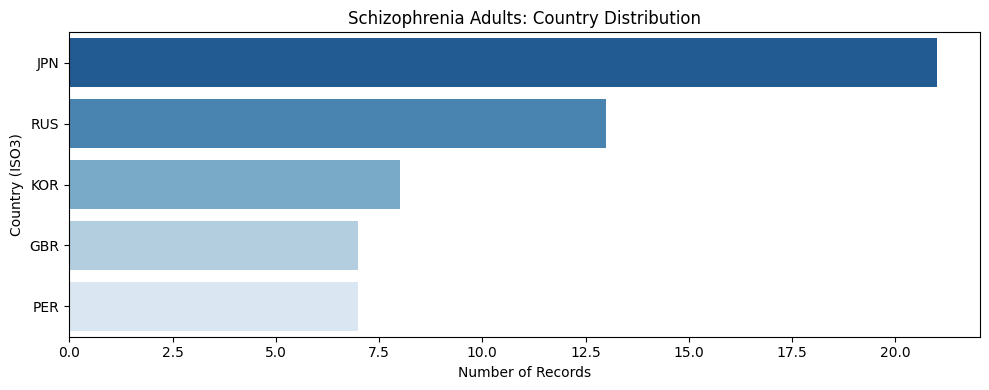

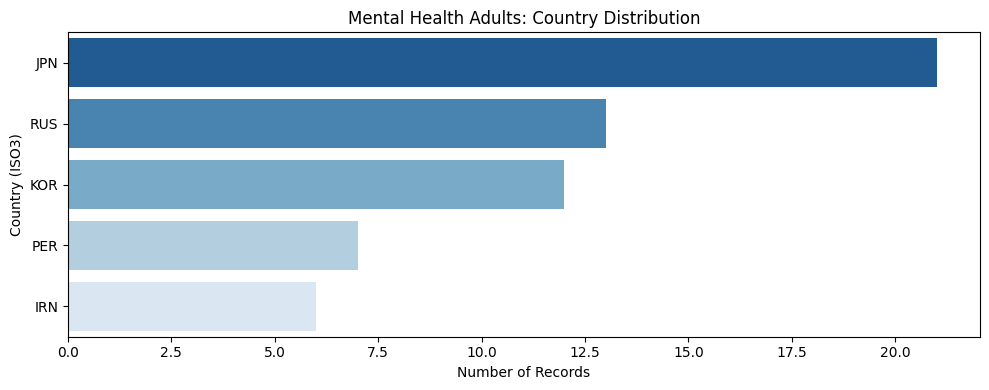

In [30]:
# Top 5 country row distribution, with a minimum of 5 entries, for each dataframe 
analysis.plot_country_distribution(ed_adults_df, title="ED Adults: Country Distribution", top_n=5)
analysis.plot_country_distribution(schiz_adults_df, title="Schizophrenia Adults: Country Distribution", top_n=5)
analysis.plot_country_distribution(mh_adults_df, title="Mental Health Adults: Country Distribution", top_n=5)

In [31]:
# Grouping ISO3 codes into regions
iso3_to_region = {
    # Africa
    'DZA':'Northern Africa', 'EGY':'Northern Africa','LBY':'Northern Africa','MOR':'Northern Africa','SDN':'Northern Africa','TUN':'Northern Africa',
    'AGO':'Sub-Saharan Africa','BWA':'Sub-Saharan Africa','BDI':'Sub-Saharan Africa','CMR':'Sub-Saharan Africa','CAF':'Sub-Saharan Africa',
    'TCD':'Sub-Saharan Africa','COG':'Sub-Saharan Africa','COD':'Sub-Saharan Africa','SWZ':'Sub-Saharan Africa','ETH':'Sub-Saharan Africa',
    'GAB':'Sub-Saharan Africa','GHA':'Sub-Saharan Africa','GIN':'Sub-Saharan Africa','CIV':'Sub-Saharan Africa','KEN':'Sub-Saharan Africa',
    'LSO':'Sub-Saharan Africa','LBR':'Sub-Saharan Africa','MDG':'Sub-Saharan Africa','MWI':'Sub-Saharan Africa','MLI':'Sub-Saharan Africa',
    'MOZ':'Sub-Saharan Africa','NAM':'Sub-Saharan Africa','NER':'Sub-Saharan Africa','NGA':'Sub-Saharan Africa','RWA':'Sub-Saharan Africa',
    'SEN':'Sub-Saharan Africa','SLE':'Sub-Saharan Africa','SOM':'Sub-Saharan Africa','ZAF':'Sub-Saharan Africa','TZA':'Sub-Saharan Africa',
    'UGA':'Sub-Saharan Africa','ZMB':'Sub-Saharan Africa','ZWE':'Sub-Saharan Africa',
    # Americas
    'CAN':'Northern America','USA':'Northern America',
    'BLZ':'Central America','CRI':'Central America','SLV':'Central America','GTM':'Central America','HND':'Central America','NIC':'Central America',
    'PAN':'Central America',
    'ARG':'South America','BOL':'South America','BRA':'South America','CHL':'South America','COL':'South America','ECU':'South America',
    'PRY':'South America','PER':'South America','URY':'South America','VEN':'South America',
    'ATG':'Caribbean','BHS':'Caribbean','BRB':'Caribbean','CUB':'Caribbean','DOM':'Caribbean','GRD':'Caribbean','HTI':'Caribbean',
    'JAM':'Caribbean','KNA':'Caribbean','LCA':'Caribbean','VCT':'Caribbean',
    'MEX':'Latin America',  # Mexico sometimes grouped in Latin America overall
    # Asia
    'CHN':'Eastern Asia','JPN':'Eastern Asia','KOR':'Eastern Asia','MNG':'Eastern Asia',
    'IND':'Southern Asia','PAK':'Southern Asia','BGD':'Southern Asia','NPL':'Southern Asia','LKA':'Southern Asia','BTN':'Southern Asia','MDV':'Southern Asia','AFG':'Southern Asia',
    'IDN':'South-Eastern Asia','MYS':'South-Eastern Asia','PHL':'South-Eastern Asia','SGP':'South-Eastern Asia','THA':'South-Eastern Asia','VNM':'South-Eastern Asia','MMR':'South-Eastern Asia','BRN':'South-Eastern Asia','KHM':'South-Eastern Asia','LAO':'South-Eastern Asia','TLS':'South-Eastern Asia','SGS':'South-Eastern Asia',
    'AZE':'Western Asia','ARM':'Western Asia','IRN':'Western Asia','IRQ':'Western Asia','ISR':'Western Asia','JOR':'Western Asia','KWT':'Western Asia','LBN':'Western Asia','OMN':'Western Asia','QAT':'Western Asia','SAU':'Western Asia','SYR':'Western Asia','ARE':'Western Asia','YEM':'Western Asia','TUR':'Western Asia','PSE':'Western Asia',
    # Europe
    'ALB':'Southern Europe','AND':'Southern Europe','BIH':'Southern Europe','HRV':'Southern Europe','GRC':'Southern Europe','ITA':'Southern Europe','MLT':'Southern Europe','MNE':'Southern Europe','PRT':'Southern Europe','SMR':'Southern Europe','SRB':'Southern Europe','SVN':'Southern Europe','ESP':'Southern Europe','VAT':'Southern Europe',
    'AUT':'Western Europe','BEL':'Western Europe','FRA':'Western Europe','DEU':'Western Europe','IRL':'Western Europe','LUX':'Western Europe','MCO':'Western Europe','NLD':'Western Europe','CHE':'Western Europe','GBR':'Western Europe',
    'BLR':'Northern Europe','DNK':'Northern Europe','EST':'Northern Europe','FIN':'Northern Europe','ISL':'Northern Europe','IRL':'Northern Europe','LVA':'Northern Europe','LTU':'Northern Europe','NOR':'Northern Europe','SWE':'Northern Europe','GBR':'Northern Europe',
    'CZE':'Eastern Europe','HUN':'Eastern Europe','POL':'Eastern Europe','SVK':'Eastern Europe','UKR':'Eastern Europe','BLR':'Eastern Europe','MDA':'Eastern Europe','RUS':'Eastern Europe','UZB':'Eastern Europe',
    # Oceania
    'AUS':'Australia and New Zealand','NZL':'Australia and New Zealand','FJI':'Melanesia','PNG':'Melanesia','SLB':'Melanesia','VUT':'Melanesia','FSM':'Micronesia','MHL':'Micronesia','PLW':'Micronesia',
    'KIR':'Micronesia','NRU':'Micronesia','TKL':'Micronesia','WSM':'Polynesia','TON':'Polynesia','TUV':'Polynesia','NIU':'Polynesia','TCA':'Polynesia',
    # Antarctica (optional)
    'ATA':'Antarctica'
}

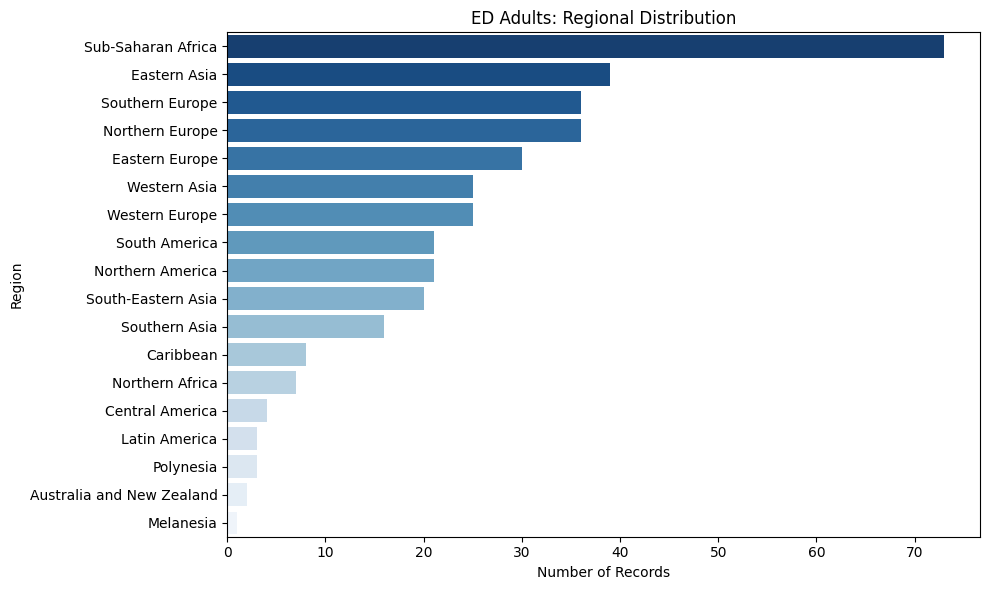

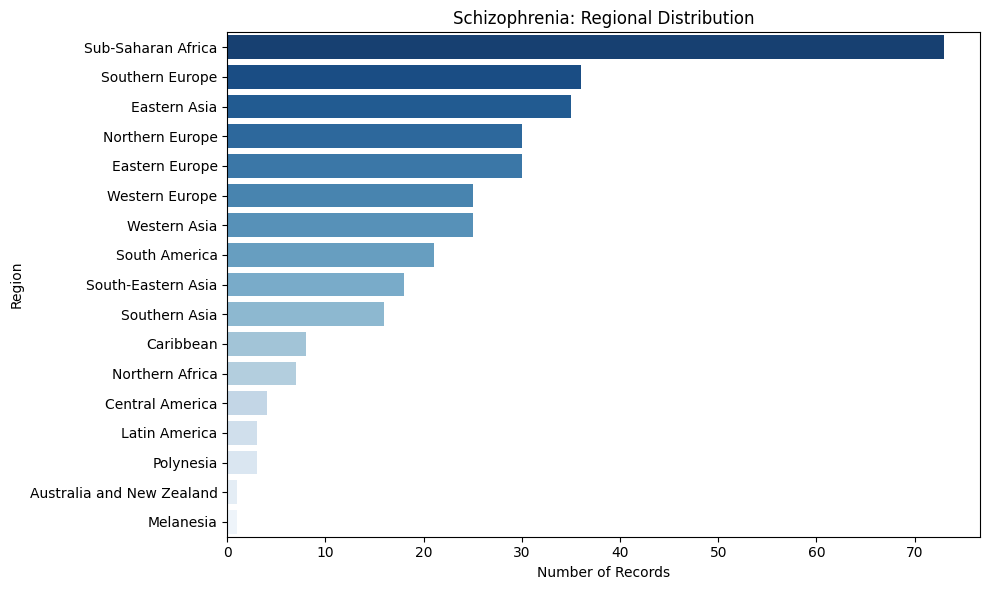

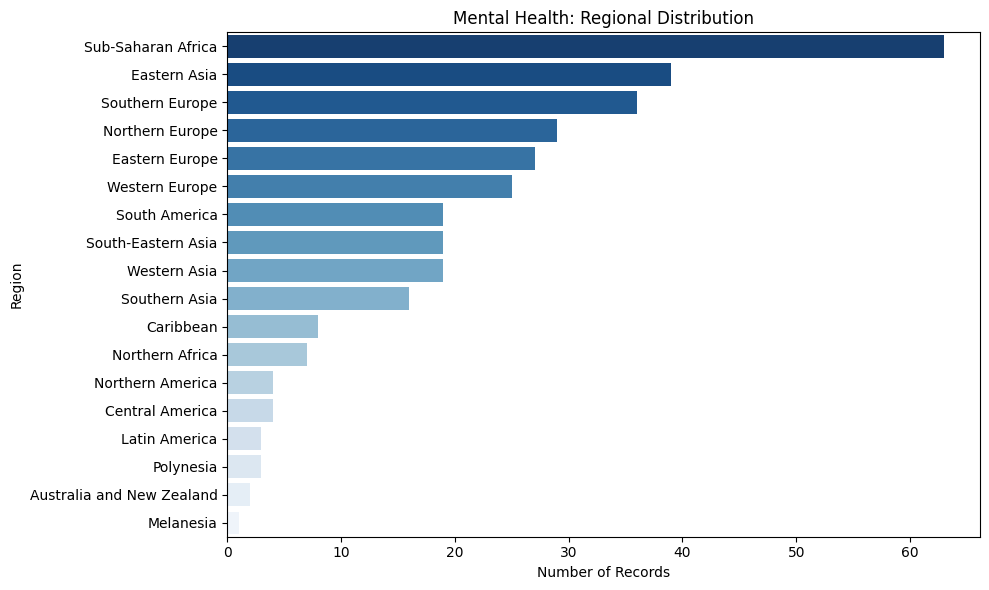

Region
Sub-Saharan Africa           63
Eastern Asia                 39
Southern Europe              36
Northern Europe              29
Eastern Europe               27
Western Europe               25
South America                19
South-Eastern Asia           19
Western Asia                 19
Southern Asia                16
Caribbean                     8
Northern Africa               7
Northern America              4
Central America               4
Latin America                 3
Polynesia                     3
Australia and New Zealand     2
Melanesia                     1
Name: count, dtype: int64

In [32]:
# Where most of the regional data is coming from
analysis.plot_region_distribution(ed_adults_df, region_map=iso3_to_region, title="ED Adults: Regional Distribution")
analysis.plot_region_distribution(schiz_adults_df, region_map=iso3_to_region, title="Schizophrenia: Regional Distribution")
analysis.plot_region_distribution(mh_adults_df, region_map=iso3_to_region, title="Mental Health: Regional Distribution")

# Conclusion 

Our analysis revealed modest and sometimes inconsistent correlations between dietary scores and mental health outcomes across countries. While higher dietary diversity and lower processed food scores were generally associated with better mental health outcomes (particularly for eating disorders and anxiety), the relationships were weak and highly variable, with no strong correlations observed for any outcome.

Limitations such as data sparsity, inconsistent reporting, and lack of individual-level or contextual variables (like socioeconomic status or access to healthcare) constrained the strength of our conclusions. Nonetheless, the findings highlight the importance of data quality and structure in global health research and point to promising directions for future studies.

For more robust insights, future work should:
* Focus on regional or country-specific analyses with more granular demographic controls
* Incorporate longitudinal or experimental data
* Control for confounding factors beyond diet

This project lays foundational work for exploring how dietary behavior may intersect with population mental health, and underscores the need for holistic, data-driven approaches to mental wellness.